In [2]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [3]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [4]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


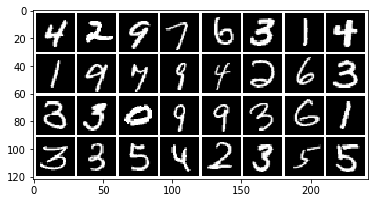

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [6]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [7]:
# Define Gen and Disc loss
def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [22]:
### Create new models ###

z_size = 784

gen = models.FCNet(imsize=(1, 1, z_size), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(1, 28, 28), s=64)

Version 0.4


In [23]:
# Set training parameters

lmd = 1e3 # loss signal

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [24]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)

z = torch.randn(sample.shape[0], 1, z_size).to(device)
gen_out = gen(z)

disc_output_real = disc(sample)
disc_output_generated = disc(gen_out)

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 473.8410949707031
Discriminator initial loss: 0.8178330659866333


In [25]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            # stack magnitudes to noise / generator input
            z = torch.randn(sample.shape[0], 1, z_size).to(device)
            
            # calc gen output
            gen.train()
            gen_output = gen(z)
            
            # calc disc output for real and generated image
            disc.train()
            disc_output_real = disc(x)
            disc_output_generated = disc(gen_output)
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen_output, x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
            d_opt.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.legend()
        plt.show()
        
    return None

In [26]:
model_name = "gan784-lmd1e3"

epoch:  1 	 step:0 	 loss: 473.8
epoch:  1 	 step:100 	 loss: 178.6
epoch:  1 	 step:200 	 loss: 145.4
epoch:  1 	 step:300 	 loss: 139.4
epoch:  1 	 step:400 	 loss: 144.9
epoch:  1 	 step:500 	 loss: 138.3
epoch:  1 	 step:600 	 loss: 149.7
epoch:  1 	 step:700 	 loss: 144.2
epoch:  1 	 step:800 	 loss: 140.8
epoch:  1 	 step:900 	 loss: 146.9
epoch:  1 	 step:1000 	 loss: 135.7
epoch:  1 	 step:1100 	 loss: 135.5
epoch:  1 	 step:1200 	 loss: 133.2
epoch:  1 	 step:1300 	 loss: 124.4
epoch:  1 	 step:1400 	 loss: 137.4
epoch:  1 	 step:1500 	 loss: 129.9
epoch:  1 	 step:1600 	 loss: 140.2
epoch:  1 	 step:1700 	 loss: 141.2
epoch:  1 	 step:1800 	 loss: 123.3


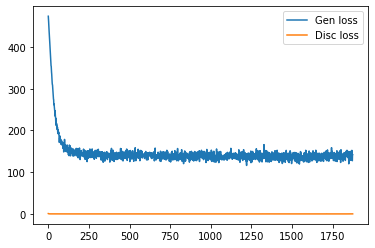

epoch:  2 	 step:0 	 loss: 127.0
epoch:  2 	 step:100 	 loss: 134.8
epoch:  2 	 step:200 	 loss: 144.4
epoch:  2 	 step:300 	 loss: 129.8
epoch:  2 	 step:400 	 loss: 137.0
epoch:  2 	 step:500 	 loss: 148.8
epoch:  2 	 step:600 	 loss: 144.8
epoch:  2 	 step:700 	 loss: 139.6
epoch:  2 	 step:800 	 loss: 147.3
epoch:  2 	 step:900 	 loss: 147.1
epoch:  2 	 step:1000 	 loss: 136.3
epoch:  2 	 step:1100 	 loss: 139.5
epoch:  2 	 step:1200 	 loss: 147.2
epoch:  2 	 step:1300 	 loss: 139.4
epoch:  2 	 step:1400 	 loss: 144.0
epoch:  2 	 step:1500 	 loss: 133.8
epoch:  2 	 step:1600 	 loss: 133.5
epoch:  2 	 step:1700 	 loss: 139.9
epoch:  2 	 step:1800 	 loss: 145.9


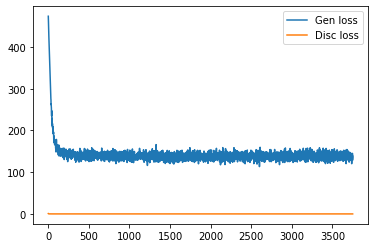

epoch:  3 	 step:0 	 loss: 134.9
epoch:  3 	 step:100 	 loss: 131.6
epoch:  3 	 step:200 	 loss: 125.0
epoch:  3 	 step:300 	 loss: 137.5
epoch:  3 	 step:400 	 loss: 138.8
epoch:  3 	 step:500 	 loss: 143.9
epoch:  3 	 step:600 	 loss: 129.5
epoch:  3 	 step:700 	 loss: 135.1
epoch:  3 	 step:800 	 loss: 149.0
epoch:  3 	 step:900 	 loss: 139.7
epoch:  3 	 step:1000 	 loss: 132.3
epoch:  3 	 step:1100 	 loss: 127.8
epoch:  3 	 step:1200 	 loss: 130.8
epoch:  3 	 step:1300 	 loss: 148.8
epoch:  3 	 step:1400 	 loss: 142.2
epoch:  3 	 step:1500 	 loss: 125.6
epoch:  3 	 step:1600 	 loss: 154.1
epoch:  3 	 step:1700 	 loss: 133.5
epoch:  3 	 step:1800 	 loss: 133.2


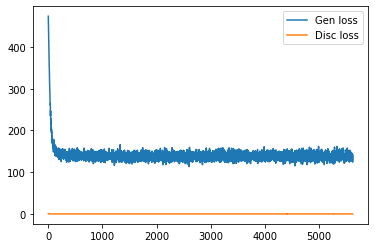

epoch:  4 	 step:0 	 loss: 134.7
epoch:  4 	 step:100 	 loss: 131.5
epoch:  4 	 step:200 	 loss: 134.3
epoch:  4 	 step:300 	 loss: 141.8
epoch:  4 	 step:400 	 loss: 119.3
epoch:  4 	 step:500 	 loss: 141.0
epoch:  4 	 step:600 	 loss: 133.9
epoch:  4 	 step:700 	 loss: 134.4
epoch:  4 	 step:800 	 loss: 130.3
epoch:  4 	 step:900 	 loss: 151.8
epoch:  4 	 step:1000 	 loss: 133.8
epoch:  4 	 step:1100 	 loss: 133.9
epoch:  4 	 step:1200 	 loss: 137.4
epoch:  4 	 step:1300 	 loss: 129.1
epoch:  4 	 step:1400 	 loss: 138.5
epoch:  4 	 step:1500 	 loss: 139.5
epoch:  4 	 step:1600 	 loss: 131.2
epoch:  4 	 step:1700 	 loss: 143.4
epoch:  4 	 step:1800 	 loss: 127.3


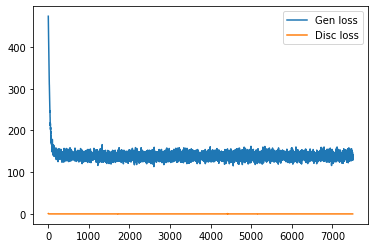

epoch:  5 	 step:0 	 loss: 154.6
epoch:  5 	 step:100 	 loss: 143.6
epoch:  5 	 step:200 	 loss: 137.4
epoch:  5 	 step:300 	 loss: 133.7
epoch:  5 	 step:400 	 loss: 138.1
epoch:  5 	 step:500 	 loss: 140.6
epoch:  5 	 step:600 	 loss: 142.7
epoch:  5 	 step:700 	 loss: 142.7
epoch:  5 	 step:800 	 loss: 143.9
epoch:  5 	 step:900 	 loss: 158.7
epoch:  5 	 step:1000 	 loss: 134.5
epoch:  5 	 step:1100 	 loss: 131.9
epoch:  5 	 step:1200 	 loss: 131.3
epoch:  5 	 step:1300 	 loss: 129.7
epoch:  5 	 step:1400 	 loss: 126.4
epoch:  5 	 step:1500 	 loss: 153.9
epoch:  5 	 step:1600 	 loss: 137.0
epoch:  5 	 step:1700 	 loss: 136.0
epoch:  5 	 step:1800 	 loss: 148.4


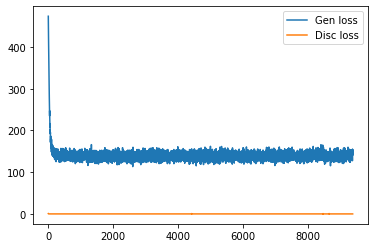

epoch:  6 	 step:0 	 loss: 147.4
epoch:  6 	 step:100 	 loss: 128.0
epoch:  6 	 step:200 	 loss: 143.4
epoch:  6 	 step:300 	 loss: 135.7
epoch:  6 	 step:400 	 loss: 136.4
epoch:  6 	 step:500 	 loss: 132.3
epoch:  6 	 step:600 	 loss: 144.4
epoch:  6 	 step:700 	 loss: 131.2
epoch:  6 	 step:800 	 loss: 135.3
epoch:  6 	 step:900 	 loss: 133.7
epoch:  6 	 step:1000 	 loss: 130.0
epoch:  6 	 step:1100 	 loss: 136.8
epoch:  6 	 step:1200 	 loss: 145.0
epoch:  6 	 step:1300 	 loss: 138.0
epoch:  6 	 step:1400 	 loss: 142.9
epoch:  6 	 step:1500 	 loss: 134.4
epoch:  6 	 step:1600 	 loss: 141.6
epoch:  6 	 step:1700 	 loss: 144.1
epoch:  6 	 step:1800 	 loss: 139.3


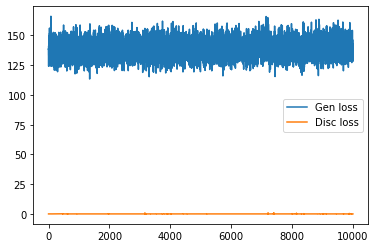

epoch:  7 	 step:0 	 loss: 139.6
epoch:  7 	 step:100 	 loss: 148.2
epoch:  7 	 step:200 	 loss: 150.1
epoch:  7 	 step:300 	 loss: 127.5
epoch:  7 	 step:400 	 loss: 134.4
epoch:  7 	 step:500 	 loss: 133.0
epoch:  7 	 step:600 	 loss: 138.1
epoch:  7 	 step:700 	 loss: 151.6
epoch:  7 	 step:800 	 loss: 123.3
epoch:  7 	 step:900 	 loss: 139.0
epoch:  7 	 step:1000 	 loss: 135.2
epoch:  7 	 step:1100 	 loss: 134.3
epoch:  7 	 step:1200 	 loss: 140.7
epoch:  7 	 step:1300 	 loss: 139.2
epoch:  7 	 step:1400 	 loss: 131.9
epoch:  7 	 step:1500 	 loss: 139.2
epoch:  7 	 step:1600 	 loss: 140.7
epoch:  7 	 step:1700 	 loss: 133.7
epoch:  7 	 step:1800 	 loss: 139.5


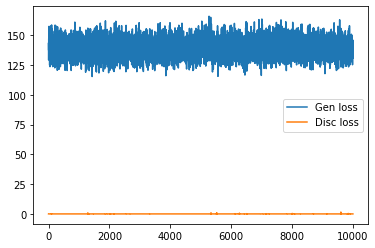

epoch:  8 	 step:0 	 loss: 139.4
epoch:  8 	 step:100 	 loss: 133.0
epoch:  8 	 step:200 	 loss: 140.3
epoch:  8 	 step:300 	 loss: 145.2
epoch:  8 	 step:400 	 loss: 140.4
epoch:  8 	 step:500 	 loss: 140.3
epoch:  8 	 step:600 	 loss: 150.4
epoch:  8 	 step:700 	 loss: 137.2
epoch:  8 	 step:800 	 loss: 141.0
epoch:  8 	 step:900 	 loss: 146.0
epoch:  8 	 step:1000 	 loss: 143.4
epoch:  8 	 step:1100 	 loss: 134.6
epoch:  8 	 step:1200 	 loss: 138.3
epoch:  8 	 step:1300 	 loss: 143.4
epoch:  8 	 step:1400 	 loss: 141.4
epoch:  8 	 step:1500 	 loss: 143.1
epoch:  8 	 step:1600 	 loss: 159.7
epoch:  8 	 step:1700 	 loss: 139.3
epoch:  8 	 step:1800 	 loss: 126.8


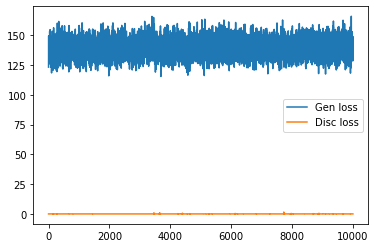

epoch:  9 	 step:0 	 loss: 141.2
epoch:  9 	 step:100 	 loss: 136.1
epoch:  9 	 step:200 	 loss: 129.4
epoch:  9 	 step:300 	 loss: 131.8
epoch:  9 	 step:400 	 loss: 135.3
epoch:  9 	 step:500 	 loss: 143.2
epoch:  9 	 step:600 	 loss: 150.4
epoch:  9 	 step:700 	 loss: 142.1
epoch:  9 	 step:800 	 loss: 132.7
epoch:  9 	 step:900 	 loss: 142.0
epoch:  9 	 step:1000 	 loss: 135.2
epoch:  9 	 step:1100 	 loss: 131.7
epoch:  9 	 step:1200 	 loss: 148.3
epoch:  9 	 step:1300 	 loss: 143.7
epoch:  9 	 step:1400 	 loss: 142.0
epoch:  9 	 step:1500 	 loss: 137.4
epoch:  9 	 step:1600 	 loss: 148.4
epoch:  9 	 step:1700 	 loss: 146.9
epoch:  9 	 step:1800 	 loss: 152.1


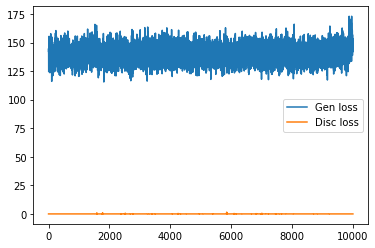

epoch: 10 	 step:0 	 loss: 140.4
epoch: 10 	 step:100 	 loss: 146.4
epoch: 10 	 step:200 	 loss: 145.5
epoch: 10 	 step:300 	 loss: 137.9
epoch: 10 	 step:400 	 loss: 152.4
epoch: 10 	 step:500 	 loss: 141.8
epoch: 10 	 step:600 	 loss: 163.6
epoch: 10 	 step:700 	 loss: 150.3
epoch: 10 	 step:800 	 loss: 150.8
epoch: 10 	 step:900 	 loss: 140.0
epoch: 10 	 step:1000 	 loss: 145.2
epoch: 10 	 step:1100 	 loss: 139.6
epoch: 10 	 step:1200 	 loss: 164.8
epoch: 10 	 step:1300 	 loss: 141.1
epoch: 10 	 step:1400 	 loss: 159.8
epoch: 10 	 step:1500 	 loss: 143.8
epoch: 10 	 step:1600 	 loss: 145.0
epoch: 10 	 step:1700 	 loss: 116.6
epoch: 10 	 step:1800 	 loss: 144.8


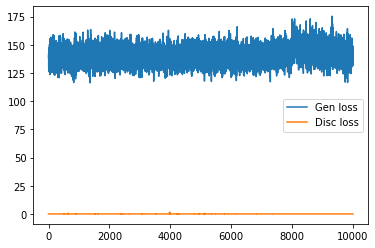

epoch: 11 	 step:0 	 loss: 145.2
epoch: 11 	 step:100 	 loss: 138.8
epoch: 11 	 step:200 	 loss: 143.3
epoch: 11 	 step:300 	 loss: 141.5
epoch: 11 	 step:400 	 loss: 142.2
epoch: 11 	 step:500 	 loss: 137.1
epoch: 11 	 step:600 	 loss: 142.6
epoch: 11 	 step:700 	 loss: 134.1
epoch: 11 	 step:800 	 loss: 125.5
epoch: 11 	 step:900 	 loss: 145.5
epoch: 11 	 step:1000 	 loss: 139.5
epoch: 11 	 step:1100 	 loss: 138.0
epoch: 11 	 step:1200 	 loss: 151.7
epoch: 11 	 step:1300 	 loss: 132.8
epoch: 11 	 step:1400 	 loss: 134.3
epoch: 11 	 step:1500 	 loss: 148.7
epoch: 11 	 step:1600 	 loss: 148.5
epoch: 11 	 step:1700 	 loss: 138.6
epoch: 11 	 step:1800 	 loss: 151.6


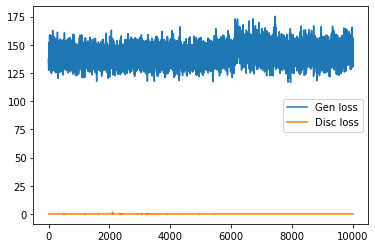

epoch: 12 	 step:0 	 loss: 139.3
epoch: 12 	 step:100 	 loss: 147.2
epoch: 12 	 step:200 	 loss: 138.0
epoch: 12 	 step:300 	 loss: 130.1
epoch: 12 	 step:400 	 loss: 137.2
epoch: 12 	 step:500 	 loss: 142.7
epoch: 12 	 step:600 	 loss: 139.1
epoch: 12 	 step:700 	 loss: 128.4
epoch: 12 	 step:800 	 loss: 157.5
epoch: 12 	 step:900 	 loss: 149.6
epoch: 12 	 step:1000 	 loss: 132.6
epoch: 12 	 step:1100 	 loss: 133.3
epoch: 12 	 step:1200 	 loss: 147.4
epoch: 12 	 step:1300 	 loss: 148.1
epoch: 12 	 step:1400 	 loss: 140.4
epoch: 12 	 step:1500 	 loss: 134.8
epoch: 12 	 step:1600 	 loss: 156.2
epoch: 12 	 step:1700 	 loss: 139.2
epoch: 12 	 step:1800 	 loss: 155.6


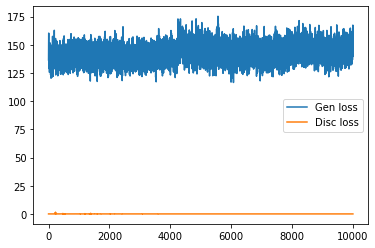

epoch: 13 	 step:0 	 loss: 138.3
epoch: 13 	 step:100 	 loss: 131.7
epoch: 13 	 step:200 	 loss: 145.6
epoch: 13 	 step:300 	 loss: 149.4
epoch: 13 	 step:400 	 loss: 142.4
epoch: 13 	 step:500 	 loss: 137.3
epoch: 13 	 step:600 	 loss: 147.3
epoch: 13 	 step:700 	 loss: 143.3
epoch: 13 	 step:800 	 loss: 141.3
epoch: 13 	 step:900 	 loss: 138.6
epoch: 13 	 step:1000 	 loss: 145.7
epoch: 13 	 step:1100 	 loss: 159.3
epoch: 13 	 step:1200 	 loss: 142.1
epoch: 13 	 step:1300 	 loss: 153.6
epoch: 13 	 step:1400 	 loss: 160.2
epoch: 13 	 step:1500 	 loss: 154.6
epoch: 13 	 step:1600 	 loss: 152.8
epoch: 13 	 step:1700 	 loss: 134.8
epoch: 13 	 step:1800 	 loss: 137.7


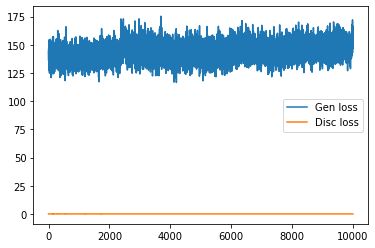

epoch: 14 	 step:0 	 loss: 142.6
epoch: 14 	 step:100 	 loss: 150.7
epoch: 14 	 step:200 	 loss: 136.8
epoch: 14 	 step:300 	 loss: 146.5
epoch: 14 	 step:400 	 loss: 141.5
epoch: 14 	 step:500 	 loss: 150.9
epoch: 14 	 step:600 	 loss: 137.6
epoch: 14 	 step:700 	 loss: 141.0
epoch: 14 	 step:800 	 loss: 148.6
epoch: 14 	 step:900 	 loss: 140.5
epoch: 14 	 step:1000 	 loss: 144.1
epoch: 14 	 step:1100 	 loss: 137.4
epoch: 14 	 step:1200 	 loss: 147.3
epoch: 14 	 step:1300 	 loss: 137.9
epoch: 14 	 step:1400 	 loss: 138.8
epoch: 14 	 step:1500 	 loss: 152.7
epoch: 14 	 step:1600 	 loss: 143.3
epoch: 14 	 step:1700 	 loss: 150.2
epoch: 14 	 step:1800 	 loss: 138.4


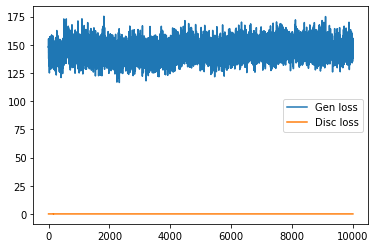

epoch: 15 	 step:0 	 loss: 161.0
epoch: 15 	 step:100 	 loss: 137.8
epoch: 15 	 step:200 	 loss: 149.9
epoch: 15 	 step:300 	 loss: 142.4
epoch: 15 	 step:400 	 loss: 155.9
epoch: 15 	 step:500 	 loss: 136.4
epoch: 15 	 step:600 	 loss: 157.8
epoch: 15 	 step:700 	 loss: 153.9
epoch: 15 	 step:800 	 loss: 140.9
epoch: 15 	 step:900 	 loss: 153.9
epoch: 15 	 step:1000 	 loss: 143.6
epoch: 15 	 step:1100 	 loss: 140.0
epoch: 15 	 step:1200 	 loss: 132.4
epoch: 15 	 step:1300 	 loss: 152.9
epoch: 15 	 step:1400 	 loss: 141.7
epoch: 15 	 step:1500 	 loss: 141.2
epoch: 15 	 step:1600 	 loss: 136.3
epoch: 15 	 step:1700 	 loss: 148.1
epoch: 15 	 step:1800 	 loss: 139.9


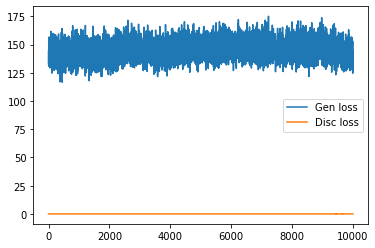

epoch: 16 	 step:0 	 loss: 147.7
epoch: 16 	 step:100 	 loss: 136.4
epoch: 16 	 step:200 	 loss: 134.2
epoch: 16 	 step:300 	 loss: 138.5
epoch: 16 	 step:400 	 loss: 153.2
epoch: 16 	 step:500 	 loss: 135.5
epoch: 16 	 step:600 	 loss: 140.5
epoch: 16 	 step:700 	 loss: 135.5
epoch: 16 	 step:800 	 loss: 139.7
epoch: 16 	 step:900 	 loss: 148.5
epoch: 16 	 step:1000 	 loss: 150.9
epoch: 16 	 step:1100 	 loss: 154.4
epoch: 16 	 step:1200 	 loss: 146.1
epoch: 16 	 step:1300 	 loss: 134.0
epoch: 16 	 step:1400 	 loss: 145.8
epoch: 16 	 step:1500 	 loss: 145.1
epoch: 16 	 step:1600 	 loss: 121.7
epoch: 16 	 step:1700 	 loss: 130.7
epoch: 16 	 step:1800 	 loss: 141.4


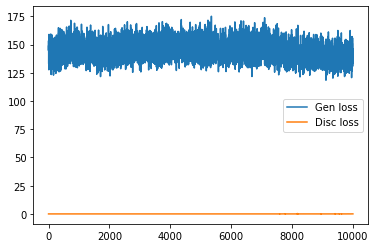

epoch: 17 	 step:0 	 loss: 136.7
epoch: 17 	 step:100 	 loss: 148.1
epoch: 17 	 step:200 	 loss: 135.7
epoch: 17 	 step:300 	 loss: 145.1
epoch: 17 	 step:400 	 loss: 143.5
epoch: 17 	 step:500 	 loss: 146.7
epoch: 17 	 step:600 	 loss: 143.2
epoch: 17 	 step:700 	 loss: 142.7
epoch: 17 	 step:800 	 loss: 127.5
epoch: 17 	 step:900 	 loss: 128.6
epoch: 17 	 step:1000 	 loss: 131.9
epoch: 17 	 step:1100 	 loss: 143.9
epoch: 17 	 step:1200 	 loss: 130.3
epoch: 17 	 step:1300 	 loss: 139.2
epoch: 17 	 step:1400 	 loss: 151.5
epoch: 17 	 step:1500 	 loss: 134.2
epoch: 17 	 step:1600 	 loss: 137.3
epoch: 17 	 step:1700 	 loss: 132.0
epoch: 17 	 step:1800 	 loss: 127.1


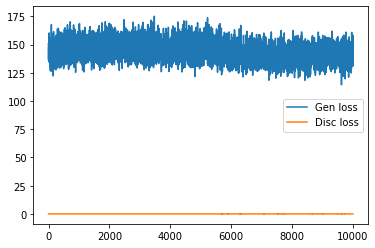

epoch: 18 	 step:0 	 loss: 151.6
epoch: 18 	 step:100 	 loss: 143.9
epoch: 18 	 step:200 	 loss: 138.9
epoch: 18 	 step:300 	 loss: 136.2
epoch: 18 	 step:400 	 loss: 145.5
epoch: 18 	 step:500 	 loss: 153.1
epoch: 18 	 step:600 	 loss: 132.3
epoch: 18 	 step:700 	 loss: 151.1
epoch: 18 	 step:800 	 loss: 131.5
epoch: 18 	 step:900 	 loss: 145.1
epoch: 18 	 step:1000 	 loss: 146.8
epoch: 18 	 step:1100 	 loss: 137.4
epoch: 18 	 step:1200 	 loss: 145.3
epoch: 18 	 step:1300 	 loss: 138.0
epoch: 18 	 step:1400 	 loss: 149.6
epoch: 18 	 step:1500 	 loss: 138.1
epoch: 18 	 step:1600 	 loss: 148.1
epoch: 18 	 step:1700 	 loss: 142.4
epoch: 18 	 step:1800 	 loss: 141.5


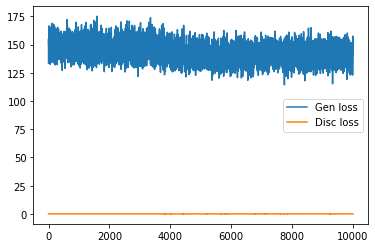

epoch: 19 	 step:0 	 loss: 139.9
epoch: 19 	 step:100 	 loss: 136.8
epoch: 19 	 step:200 	 loss: 152.6
epoch: 19 	 step:300 	 loss: 144.9
epoch: 19 	 step:400 	 loss: 141.3
epoch: 19 	 step:500 	 loss: 139.0
epoch: 19 	 step:600 	 loss: 149.6
epoch: 19 	 step:700 	 loss: 135.3
epoch: 19 	 step:800 	 loss: 136.2
epoch: 19 	 step:900 	 loss: 145.5
epoch: 19 	 step:1000 	 loss: 161.6
epoch: 19 	 step:1100 	 loss: 151.8
epoch: 19 	 step:1200 	 loss: 136.5
epoch: 19 	 step:1300 	 loss: 127.6
epoch: 19 	 step:1400 	 loss: 151.7
epoch: 19 	 step:1500 	 loss: 152.6
epoch: 19 	 step:1600 	 loss: 141.5
epoch: 19 	 step:1700 	 loss: 147.3
epoch: 19 	 step:1800 	 loss: 143.2


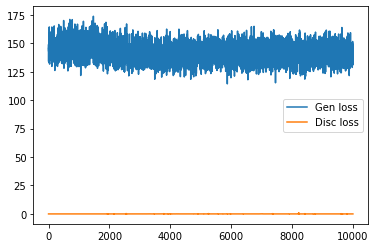

epoch: 20 	 step:0 	 loss: 132.3
epoch: 20 	 step:100 	 loss: 139.8
epoch: 20 	 step:200 	 loss: 131.2
epoch: 20 	 step:300 	 loss: 127.8
epoch: 20 	 step:400 	 loss: 138.4
epoch: 20 	 step:500 	 loss: 146.4
epoch: 20 	 step:600 	 loss: 141.5
epoch: 20 	 step:700 	 loss: 130.9
epoch: 20 	 step:800 	 loss: 147.1
epoch: 20 	 step:900 	 loss: 137.4
epoch: 20 	 step:1000 	 loss: 140.5
epoch: 20 	 step:1100 	 loss: 127.2
epoch: 20 	 step:1200 	 loss: 148.8
epoch: 20 	 step:1300 	 loss: 137.6
epoch: 20 	 step:1400 	 loss: 140.4
epoch: 20 	 step:1500 	 loss: 138.8
epoch: 20 	 step:1600 	 loss: 141.0
epoch: 20 	 step:1700 	 loss: 139.6
epoch: 20 	 step:1800 	 loss: 140.8


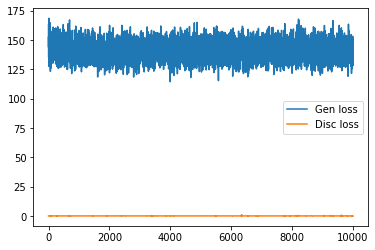

epoch: 21 	 step:0 	 loss: 132.6
epoch: 21 	 step:100 	 loss: 142.8
epoch: 21 	 step:200 	 loss: 133.2
epoch: 21 	 step:300 	 loss: 139.7
epoch: 21 	 step:400 	 loss: 149.7
epoch: 21 	 step:500 	 loss: 151.7
epoch: 21 	 step:600 	 loss: 141.3
epoch: 21 	 step:700 	 loss: 132.9
epoch: 21 	 step:800 	 loss: 148.8
epoch: 21 	 step:900 	 loss: 142.3
epoch: 21 	 step:1000 	 loss: 139.1
epoch: 21 	 step:1100 	 loss: 138.6
epoch: 21 	 step:1200 	 loss: 143.2
epoch: 21 	 step:1300 	 loss: 147.7
epoch: 21 	 step:1400 	 loss: 147.1
epoch: 21 	 step:1500 	 loss: 136.7
epoch: 21 	 step:1600 	 loss: 130.2
epoch: 21 	 step:1700 	 loss: 150.5
epoch: 21 	 step:1800 	 loss: 143.5


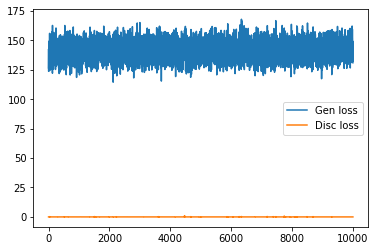

epoch: 22 	 step:0 	 loss: 146.8
epoch: 22 	 step:100 	 loss: 146.3
epoch: 22 	 step:200 	 loss: 134.6
epoch: 22 	 step:300 	 loss: 150.6
epoch: 22 	 step:400 	 loss: 143.9
epoch: 22 	 step:500 	 loss: 137.6
epoch: 22 	 step:600 	 loss: 137.2
epoch: 22 	 step:700 	 loss: 141.5
epoch: 22 	 step:800 	 loss: 127.1
epoch: 22 	 step:900 	 loss: 141.5
epoch: 22 	 step:1000 	 loss: 137.0
epoch: 22 	 step:1100 	 loss: 147.1
epoch: 22 	 step:1200 	 loss: 142.1
epoch: 22 	 step:1300 	 loss: 134.7
epoch: 22 	 step:1400 	 loss: 136.5
epoch: 22 	 step:1500 	 loss: 149.7
epoch: 22 	 step:1600 	 loss: 163.9
epoch: 22 	 step:1700 	 loss: 143.8
epoch: 22 	 step:1800 	 loss: 149.5


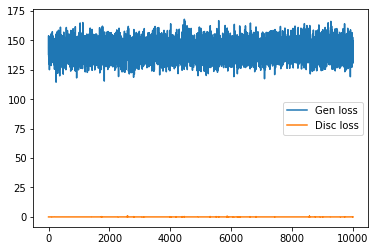

epoch: 23 	 step:0 	 loss: 148.3
epoch: 23 	 step:100 	 loss: 145.3
epoch: 23 	 step:200 	 loss: 139.4
epoch: 23 	 step:300 	 loss: 148.7
epoch: 23 	 step:400 	 loss: 137.6
epoch: 23 	 step:500 	 loss: 150.9
epoch: 23 	 step:600 	 loss: 139.6
epoch: 23 	 step:700 	 loss: 132.6
epoch: 23 	 step:800 	 loss: 144.5
epoch: 23 	 step:900 	 loss: 143.1
epoch: 23 	 step:1000 	 loss: 142.9
epoch: 23 	 step:1100 	 loss: 157.5
epoch: 23 	 step:1200 	 loss: 137.9
epoch: 23 	 step:1300 	 loss: 130.9
epoch: 23 	 step:1400 	 loss: 138.5
epoch: 23 	 step:1500 	 loss: 139.5
epoch: 23 	 step:1600 	 loss: 142.4
epoch: 23 	 step:1700 	 loss: 145.6
epoch: 23 	 step:1800 	 loss: 140.9


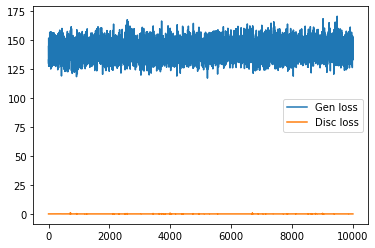

epoch: 24 	 step:0 	 loss: 131.6
epoch: 24 	 step:100 	 loss: 142.0
epoch: 24 	 step:200 	 loss: 146.4
epoch: 24 	 step:300 	 loss: 150.8
epoch: 24 	 step:400 	 loss: 132.0
epoch: 24 	 step:500 	 loss: 138.5
epoch: 24 	 step:600 	 loss: 140.8
epoch: 24 	 step:700 	 loss: 159.5
epoch: 24 	 step:800 	 loss: 148.9
epoch: 24 	 step:900 	 loss: 128.4
epoch: 24 	 step:1000 	 loss: 141.5
epoch: 24 	 step:1100 	 loss: 146.0
epoch: 24 	 step:1200 	 loss: 143.1
epoch: 24 	 step:1300 	 loss: 140.0
epoch: 24 	 step:1400 	 loss: 139.7
epoch: 24 	 step:1500 	 loss: 137.7
epoch: 24 	 step:1600 	 loss: 138.9
epoch: 24 	 step:1700 	 loss: 142.9
epoch: 24 	 step:1800 	 loss: 144.9


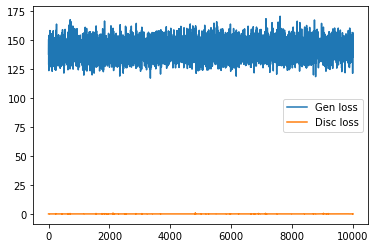

epoch: 25 	 step:0 	 loss: 162.0
epoch: 25 	 step:100 	 loss: 133.4
epoch: 25 	 step:200 	 loss: 154.6
epoch: 25 	 step:300 	 loss: 140.6
epoch: 25 	 step:400 	 loss: 134.8
epoch: 25 	 step:500 	 loss: 151.7
epoch: 25 	 step:600 	 loss: 143.2
epoch: 25 	 step:700 	 loss: 140.8
epoch: 25 	 step:800 	 loss: 136.3
epoch: 25 	 step:900 	 loss: 144.8
epoch: 25 	 step:1000 	 loss: 152.8
epoch: 25 	 step:1100 	 loss: 127.8
epoch: 25 	 step:1200 	 loss: 137.1
epoch: 25 	 step:1300 	 loss: 140.2
epoch: 25 	 step:1400 	 loss: 145.3
epoch: 25 	 step:1500 	 loss: 140.9
epoch: 25 	 step:1600 	 loss: 149.9
epoch: 25 	 step:1700 	 loss: 147.0
epoch: 25 	 step:1800 	 loss: 131.1


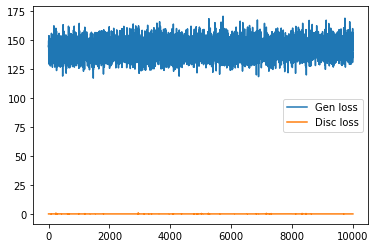

epoch: 26 	 step:0 	 loss: 137.7
epoch: 26 	 step:100 	 loss: 142.3
epoch: 26 	 step:200 	 loss: 147.3
epoch: 26 	 step:300 	 loss: 163.8
epoch: 26 	 step:400 	 loss: 141.5
epoch: 26 	 step:500 	 loss: 139.1
epoch: 26 	 step:600 	 loss: 137.1
epoch: 26 	 step:700 	 loss: 141.9
epoch: 26 	 step:800 	 loss: 136.6
epoch: 26 	 step:900 	 loss: 144.4
epoch: 26 	 step:1000 	 loss: 144.8
epoch: 26 	 step:1100 	 loss: 142.0
epoch: 26 	 step:1200 	 loss: 128.1
epoch: 26 	 step:1300 	 loss: 137.3
epoch: 26 	 step:1400 	 loss: 152.8
epoch: 26 	 step:1500 	 loss: 144.2
epoch: 26 	 step:1600 	 loss: 143.2
epoch: 26 	 step:1700 	 loss: 137.3
epoch: 26 	 step:1800 	 loss: 141.3


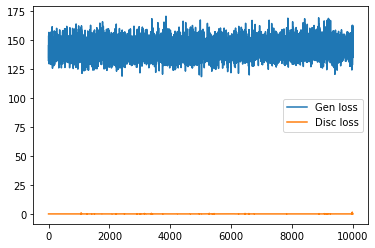

epoch: 27 	 step:0 	 loss: 147.3
epoch: 27 	 step:100 	 loss: 151.9
epoch: 27 	 step:200 	 loss: 144.7
epoch: 27 	 step:300 	 loss: 149.4
epoch: 27 	 step:400 	 loss: 138.1
epoch: 27 	 step:500 	 loss: 146.4
epoch: 27 	 step:600 	 loss: 127.5
epoch: 27 	 step:700 	 loss: 132.6
epoch: 27 	 step:800 	 loss: 141.8
epoch: 27 	 step:900 	 loss: 151.7
epoch: 27 	 step:1000 	 loss: 147.9
epoch: 27 	 step:1100 	 loss: 138.0
epoch: 27 	 step:1200 	 loss: 142.2
epoch: 27 	 step:1300 	 loss: 142.3
epoch: 27 	 step:1400 	 loss: 148.8
epoch: 27 	 step:1500 	 loss: 136.0
epoch: 27 	 step:1600 	 loss: 144.3
epoch: 27 	 step:1700 	 loss: 148.5
epoch: 27 	 step:1800 	 loss: 139.4


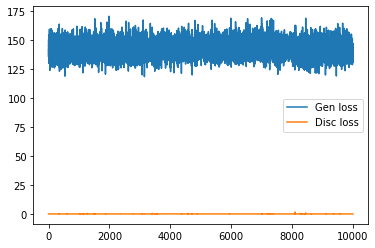

epoch: 28 	 step:0 	 loss: 138.6
epoch: 28 	 step:100 	 loss: 145.0
epoch: 28 	 step:200 	 loss: 141.8
epoch: 28 	 step:300 	 loss: 141.4
epoch: 28 	 step:400 	 loss: 138.9
epoch: 28 	 step:500 	 loss: 135.6
epoch: 28 	 step:600 	 loss: 146.9
epoch: 28 	 step:700 	 loss: 135.9
epoch: 28 	 step:800 	 loss: 143.5
epoch: 28 	 step:900 	 loss: 149.3
epoch: 28 	 step:1000 	 loss: 151.6
epoch: 28 	 step:1100 	 loss: 147.9
epoch: 28 	 step:1200 	 loss: 147.4
epoch: 28 	 step:1300 	 loss: 146.6
epoch: 28 	 step:1400 	 loss: 140.6
epoch: 28 	 step:1500 	 loss: 132.1
epoch: 28 	 step:1600 	 loss: 137.3
epoch: 28 	 step:1700 	 loss: 135.3
epoch: 28 	 step:1800 	 loss: 141.7


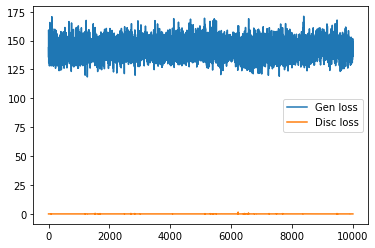

epoch: 29 	 step:0 	 loss: 147.4
epoch: 29 	 step:100 	 loss: 147.6
epoch: 29 	 step:200 	 loss: 150.3
epoch: 29 	 step:300 	 loss: 130.9
epoch: 29 	 step:400 	 loss: 139.7
epoch: 29 	 step:500 	 loss: 134.8
epoch: 29 	 step:600 	 loss: 158.3
epoch: 29 	 step:700 	 loss: 142.9
epoch: 29 	 step:800 	 loss: 139.4
epoch: 29 	 step:900 	 loss: 134.1
epoch: 29 	 step:1000 	 loss: 156.6
epoch: 29 	 step:1100 	 loss: 135.8
epoch: 29 	 step:1200 	 loss: 146.0
epoch: 29 	 step:1300 	 loss: 150.2
epoch: 29 	 step:1400 	 loss: 142.6
epoch: 29 	 step:1500 	 loss: 138.0
epoch: 29 	 step:1600 	 loss: 151.8
epoch: 29 	 step:1700 	 loss: 135.4
epoch: 29 	 step:1800 	 loss: 156.1


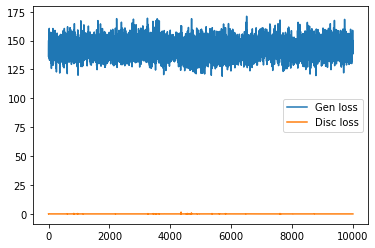

epoch: 30 	 step:0 	 loss: 143.5
epoch: 30 	 step:100 	 loss: 137.6
epoch: 30 	 step:200 	 loss: 143.3
epoch: 30 	 step:300 	 loss: 148.3
epoch: 30 	 step:400 	 loss: 139.6
epoch: 30 	 step:500 	 loss: 157.8
epoch: 30 	 step:600 	 loss: 138.2
epoch: 30 	 step:700 	 loss: 133.9
epoch: 30 	 step:800 	 loss: 140.2
epoch: 30 	 step:900 	 loss: 148.1
epoch: 30 	 step:1000 	 loss: 139.6
epoch: 30 	 step:1100 	 loss: 135.7
epoch: 30 	 step:1200 	 loss: 160.4
epoch: 30 	 step:1300 	 loss: 149.4
epoch: 30 	 step:1400 	 loss: 135.3
epoch: 30 	 step:1500 	 loss: 160.7
epoch: 30 	 step:1600 	 loss: 146.1
epoch: 30 	 step:1700 	 loss: 137.8
epoch: 30 	 step:1800 	 loss: 133.4


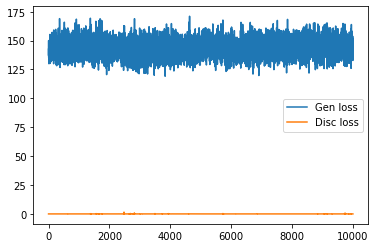

epoch: 31 	 step:0 	 loss: 153.3
epoch: 31 	 step:100 	 loss: 141.9
epoch: 31 	 step:200 	 loss: 154.3
epoch: 31 	 step:300 	 loss: 148.1
epoch: 31 	 step:400 	 loss: 138.1
epoch: 31 	 step:500 	 loss: 141.6
epoch: 31 	 step:600 	 loss: 135.1
epoch: 31 	 step:700 	 loss: 134.8
epoch: 31 	 step:800 	 loss: 136.6
epoch: 31 	 step:900 	 loss: 155.3
epoch: 31 	 step:1000 	 loss: 143.3
epoch: 31 	 step:1100 	 loss: 145.9
epoch: 31 	 step:1200 	 loss: 142.0
epoch: 31 	 step:1300 	 loss: 132.6
epoch: 31 	 step:1400 	 loss: 145.3
epoch: 31 	 step:1500 	 loss: 147.8
epoch: 31 	 step:1600 	 loss: 153.2
epoch: 31 	 step:1700 	 loss: 129.3
epoch: 31 	 step:1800 	 loss: 150.3


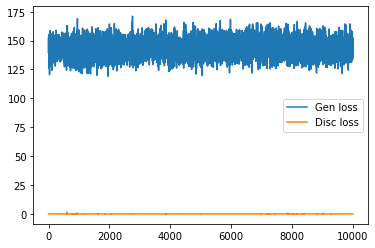

epoch: 32 	 step:0 	 loss: 153.5
epoch: 32 	 step:100 	 loss: 136.3
epoch: 32 	 step:200 	 loss: 140.4
epoch: 32 	 step:300 	 loss: 129.3
epoch: 32 	 step:400 	 loss: 134.7
epoch: 32 	 step:500 	 loss: 140.1
epoch: 32 	 step:600 	 loss: 143.3
epoch: 32 	 step:700 	 loss: 150.4
epoch: 32 	 step:800 	 loss: 136.4
epoch: 32 	 step:900 	 loss: 152.2
epoch: 32 	 step:1000 	 loss: 143.4
epoch: 32 	 step:1100 	 loss: 142.4
epoch: 32 	 step:1200 	 loss: 144.1
epoch: 32 	 step:1300 	 loss: 166.7
epoch: 32 	 step:1400 	 loss: 142.9
epoch: 32 	 step:1500 	 loss: 149.9
epoch: 32 	 step:1600 	 loss: 141.6
epoch: 32 	 step:1700 	 loss: 132.8
epoch: 32 	 step:1800 	 loss: 134.8


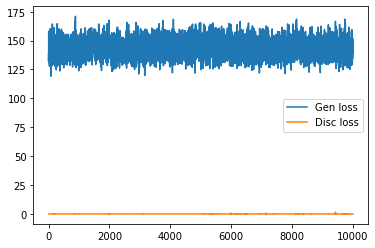

epoch: 33 	 step:0 	 loss: 152.4
epoch: 33 	 step:100 	 loss: 141.3
epoch: 33 	 step:200 	 loss: 147.4
epoch: 33 	 step:300 	 loss: 142.7
epoch: 33 	 step:400 	 loss: 132.5
epoch: 33 	 step:500 	 loss: 139.1
epoch: 33 	 step:600 	 loss: 153.0
epoch: 33 	 step:700 	 loss: 136.7
epoch: 33 	 step:800 	 loss: 163.7
epoch: 33 	 step:900 	 loss: 128.3
epoch: 33 	 step:1000 	 loss: 147.0
epoch: 33 	 step:1100 	 loss: 143.0
epoch: 33 	 step:1200 	 loss: 152.4
epoch: 33 	 step:1300 	 loss: 162.9
epoch: 33 	 step:1400 	 loss: 147.8
epoch: 33 	 step:1500 	 loss: 141.2
epoch: 33 	 step:1600 	 loss: 129.1
epoch: 33 	 step:1700 	 loss: 135.4
epoch: 33 	 step:1800 	 loss: 146.6


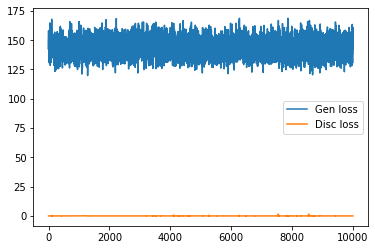

epoch: 34 	 step:0 	 loss: 137.8
epoch: 34 	 step:100 	 loss: 150.1
epoch: 34 	 step:200 	 loss: 150.2
epoch: 34 	 step:300 	 loss: 148.6
epoch: 34 	 step:400 	 loss: 141.8
epoch: 34 	 step:500 	 loss: 141.3
epoch: 34 	 step:600 	 loss: 141.5
epoch: 34 	 step:700 	 loss: 149.5
epoch: 34 	 step:800 	 loss: 152.8
epoch: 34 	 step:900 	 loss: 144.4
epoch: 34 	 step:1000 	 loss: 142.0
epoch: 34 	 step:1100 	 loss: 146.4
epoch: 34 	 step:1200 	 loss: 144.5
epoch: 34 	 step:1300 	 loss: 144.9
epoch: 34 	 step:1400 	 loss: 133.9
epoch: 34 	 step:1500 	 loss: 150.3
epoch: 34 	 step:1600 	 loss: 141.1
epoch: 34 	 step:1700 	 loss: 133.4
epoch: 34 	 step:1800 	 loss: 153.7


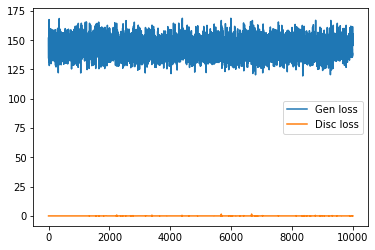

epoch: 35 	 step:0 	 loss: 150.2
epoch: 35 	 step:100 	 loss: 155.9
epoch: 35 	 step:200 	 loss: 159.7
epoch: 35 	 step:300 	 loss: 152.7
epoch: 35 	 step:400 	 loss: 144.6
epoch: 35 	 step:500 	 loss: 147.4
epoch: 35 	 step:600 	 loss: 145.8
epoch: 35 	 step:700 	 loss: 147.7
epoch: 35 	 step:800 	 loss: 135.5
epoch: 35 	 step:900 	 loss: 148.4
epoch: 35 	 step:1000 	 loss: 140.3
epoch: 35 	 step:1100 	 loss: 144.4
epoch: 35 	 step:1200 	 loss: 145.1
epoch: 35 	 step:1300 	 loss: 146.4
epoch: 35 	 step:1400 	 loss: 147.5
epoch: 35 	 step:1500 	 loss: 142.6
epoch: 35 	 step:1600 	 loss: 135.1
epoch: 35 	 step:1700 	 loss: 150.8
epoch: 35 	 step:1800 	 loss: 132.2


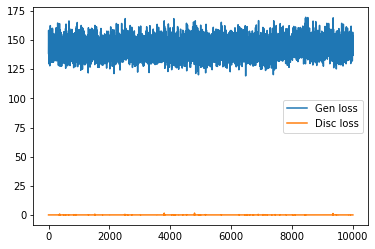

epoch: 36 	 step:0 	 loss: 143.7
epoch: 36 	 step:100 	 loss: 154.1
epoch: 36 	 step:200 	 loss: 132.8
epoch: 36 	 step:300 	 loss: 140.2
epoch: 36 	 step:400 	 loss: 141.0
epoch: 36 	 step:500 	 loss: 146.8
epoch: 36 	 step:600 	 loss: 144.5
epoch: 36 	 step:700 	 loss: 133.6
epoch: 36 	 step:800 	 loss: 156.1
epoch: 36 	 step:900 	 loss: 139.1
epoch: 36 	 step:1000 	 loss: 154.0
epoch: 36 	 step:1100 	 loss: 141.5
epoch: 36 	 step:1200 	 loss: 145.2
epoch: 36 	 step:1300 	 loss: 147.4
epoch: 36 	 step:1400 	 loss: 155.0
epoch: 36 	 step:1500 	 loss: 145.8
epoch: 36 	 step:1600 	 loss: 149.9
epoch: 36 	 step:1700 	 loss: 142.5
epoch: 36 	 step:1800 	 loss: 148.3


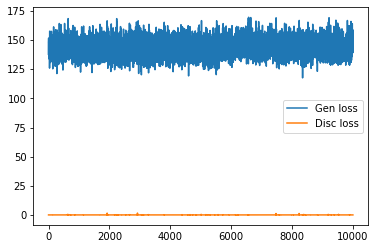

epoch: 37 	 step:0 	 loss: 141.4
epoch: 37 	 step:100 	 loss: 150.0
epoch: 37 	 step:200 	 loss: 149.3
epoch: 37 	 step:300 	 loss: 143.7
epoch: 37 	 step:400 	 loss: 145.3
epoch: 37 	 step:500 	 loss: 155.6
epoch: 37 	 step:600 	 loss: 141.0
epoch: 37 	 step:700 	 loss: 143.1
epoch: 37 	 step:800 	 loss: 144.3
epoch: 37 	 step:900 	 loss: 143.3
epoch: 37 	 step:1000 	 loss: 153.2
epoch: 37 	 step:1100 	 loss: 138.0
epoch: 37 	 step:1200 	 loss: 158.0
epoch: 37 	 step:1300 	 loss: 134.0
epoch: 37 	 step:1400 	 loss: 151.2
epoch: 37 	 step:1500 	 loss: 162.9
epoch: 37 	 step:1600 	 loss: 143.8
epoch: 37 	 step:1700 	 loss: 141.7
epoch: 37 	 step:1800 	 loss: 138.2


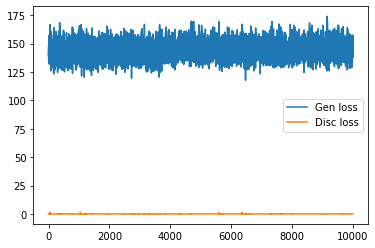

epoch: 38 	 step:0 	 loss: 145.2
epoch: 38 	 step:100 	 loss: 146.6
epoch: 38 	 step:200 	 loss: 146.6
epoch: 38 	 step:300 	 loss: 144.5
epoch: 38 	 step:400 	 loss: 153.3
epoch: 38 	 step:500 	 loss: 152.7
epoch: 38 	 step:600 	 loss: 135.7
epoch: 38 	 step:700 	 loss: 145.5
epoch: 38 	 step:800 	 loss: 149.8
epoch: 38 	 step:900 	 loss: 149.5
epoch: 38 	 step:1000 	 loss: 148.1
epoch: 38 	 step:1100 	 loss: 154.2
epoch: 38 	 step:1200 	 loss: 149.3
epoch: 38 	 step:1300 	 loss: 141.7
epoch: 38 	 step:1400 	 loss: 140.8
epoch: 38 	 step:1500 	 loss: 138.9
epoch: 38 	 step:1600 	 loss: 133.6
epoch: 38 	 step:1700 	 loss: 167.0
epoch: 38 	 step:1800 	 loss: 146.9


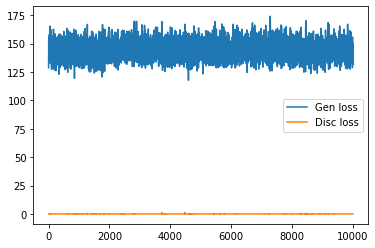

epoch: 39 	 step:0 	 loss: 143.8
epoch: 39 	 step:100 	 loss: 144.5
epoch: 39 	 step:200 	 loss: 149.4
epoch: 39 	 step:300 	 loss: 153.9
epoch: 39 	 step:400 	 loss: 152.8
epoch: 39 	 step:500 	 loss: 129.5
epoch: 39 	 step:600 	 loss: 148.6
epoch: 39 	 step:700 	 loss: 148.4
epoch: 39 	 step:800 	 loss: 143.2
epoch: 39 	 step:900 	 loss: 145.0
epoch: 39 	 step:1000 	 loss: 151.5
epoch: 39 	 step:1100 	 loss: 137.5
epoch: 39 	 step:1200 	 loss: 164.3
epoch: 39 	 step:1300 	 loss: 151.4
epoch: 39 	 step:1400 	 loss: 150.6
epoch: 39 	 step:1500 	 loss: 135.4
epoch: 39 	 step:1600 	 loss: 134.9
epoch: 39 	 step:1700 	 loss: 153.4
epoch: 39 	 step:1800 	 loss: 148.3


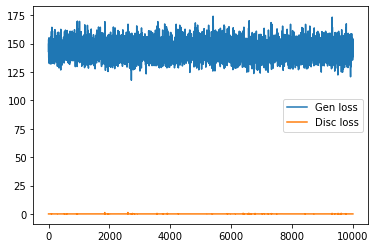

epoch: 40 	 step:0 	 loss: 145.8
epoch: 40 	 step:100 	 loss: 146.3
epoch: 40 	 step:200 	 loss: 140.1
epoch: 40 	 step:300 	 loss: 150.9
epoch: 40 	 step:400 	 loss: 140.0
epoch: 40 	 step:500 	 loss: 139.4
epoch: 40 	 step:600 	 loss: 144.0
epoch: 40 	 step:700 	 loss: 136.0
epoch: 40 	 step:800 	 loss: 146.6
epoch: 40 	 step:900 	 loss: 145.9
epoch: 40 	 step:1000 	 loss: 152.2
epoch: 40 	 step:1100 	 loss: 134.4
epoch: 40 	 step:1200 	 loss: 140.3
epoch: 40 	 step:1300 	 loss: 146.4
epoch: 40 	 step:1400 	 loss: 140.4
epoch: 40 	 step:1500 	 loss: 136.7
epoch: 40 	 step:1600 	 loss: 146.1
epoch: 40 	 step:1700 	 loss: 146.7
epoch: 40 	 step:1800 	 loss: 146.3


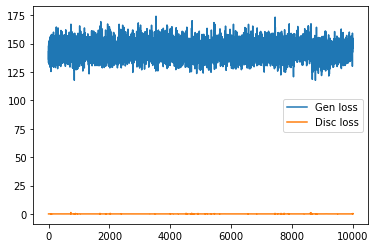

epoch: 41 	 step:0 	 loss: 139.7
epoch: 41 	 step:100 	 loss: 131.6
epoch: 41 	 step:200 	 loss: 146.5
epoch: 41 	 step:300 	 loss: 143.6
epoch: 41 	 step:400 	 loss: 142.0
epoch: 41 	 step:500 	 loss: 158.6
epoch: 41 	 step:600 	 loss: 147.7
epoch: 41 	 step:700 	 loss: 141.5
epoch: 41 	 step:800 	 loss: 149.6
epoch: 41 	 step:900 	 loss: 146.7
epoch: 41 	 step:1000 	 loss: 158.4
epoch: 41 	 step:1100 	 loss: 129.1
epoch: 41 	 step:1200 	 loss: 133.5
epoch: 41 	 step:1300 	 loss: 139.8
epoch: 41 	 step:1400 	 loss: 155.2
epoch: 41 	 step:1500 	 loss: 144.1
epoch: 41 	 step:1600 	 loss: 139.7
epoch: 41 	 step:1700 	 loss: 133.7
epoch: 41 	 step:1800 	 loss: 150.2


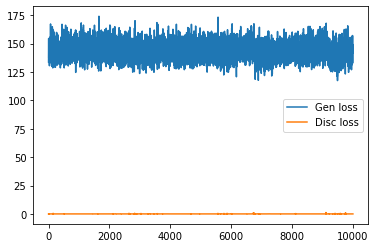

epoch: 42 	 step:0 	 loss: 149.7
epoch: 42 	 step:100 	 loss: 147.6
epoch: 42 	 step:200 	 loss: 138.8
epoch: 42 	 step:300 	 loss: 127.5
epoch: 42 	 step:400 	 loss: 152.0
epoch: 42 	 step:500 	 loss: 139.9
epoch: 42 	 step:600 	 loss: 145.4
epoch: 42 	 step:700 	 loss: 134.5
epoch: 42 	 step:800 	 loss: 148.8
epoch: 42 	 step:900 	 loss: 148.9
epoch: 42 	 step:1000 	 loss: 141.0
epoch: 42 	 step:1100 	 loss: 132.9
epoch: 42 	 step:1200 	 loss: 144.9
epoch: 42 	 step:1300 	 loss: 136.2
epoch: 42 	 step:1400 	 loss: 151.9
epoch: 42 	 step:1500 	 loss: 135.7
epoch: 42 	 step:1600 	 loss: 152.4
epoch: 42 	 step:1700 	 loss: 138.0
epoch: 42 	 step:1800 	 loss: 141.8


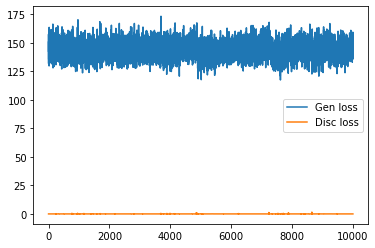

epoch: 43 	 step:0 	 loss: 143.9
epoch: 43 	 step:100 	 loss: 160.1
epoch: 43 	 step:200 	 loss: 136.5
epoch: 43 	 step:300 	 loss: 141.2
epoch: 43 	 step:400 	 loss: 133.8
epoch: 43 	 step:500 	 loss: 143.6
epoch: 43 	 step:600 	 loss: 141.0
epoch: 43 	 step:700 	 loss: 134.9
epoch: 43 	 step:800 	 loss: 147.6
epoch: 43 	 step:900 	 loss: 146.0
epoch: 43 	 step:1000 	 loss: 150.5
epoch: 43 	 step:1100 	 loss: 148.4
epoch: 43 	 step:1200 	 loss: 145.6
epoch: 43 	 step:1300 	 loss: 156.2
epoch: 43 	 step:1400 	 loss: 143.5
epoch: 43 	 step:1500 	 loss: 132.6
epoch: 43 	 step:1600 	 loss: 141.6
epoch: 43 	 step:1700 	 loss: 143.4
epoch: 43 	 step:1800 	 loss: 138.8


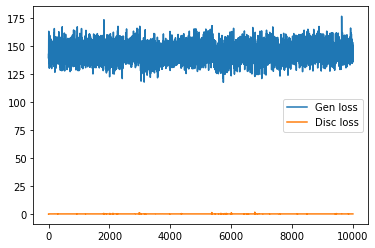

epoch: 44 	 step:0 	 loss: 149.9
epoch: 44 	 step:100 	 loss: 153.0
epoch: 44 	 step:200 	 loss: 149.1
epoch: 44 	 step:300 	 loss: 146.4
epoch: 44 	 step:400 	 loss: 142.8
epoch: 44 	 step:500 	 loss: 148.3
epoch: 44 	 step:600 	 loss: 137.5
epoch: 44 	 step:700 	 loss: 148.2
epoch: 44 	 step:800 	 loss: 152.2
epoch: 44 	 step:900 	 loss: 126.1
epoch: 44 	 step:1000 	 loss: 144.0
epoch: 44 	 step:1100 	 loss: 145.3
epoch: 44 	 step:1200 	 loss: 154.2
epoch: 44 	 step:1300 	 loss: 140.7
epoch: 44 	 step:1400 	 loss: 153.1
epoch: 44 	 step:1500 	 loss: 144.3
epoch: 44 	 step:1600 	 loss: 153.7
epoch: 44 	 step:1700 	 loss: 143.9
epoch: 44 	 step:1800 	 loss: 150.1


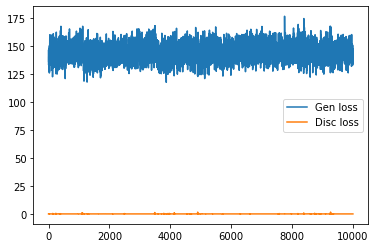

epoch: 45 	 step:0 	 loss: 149.5
epoch: 45 	 step:100 	 loss: 142.8
epoch: 45 	 step:200 	 loss: 149.9
epoch: 45 	 step:300 	 loss: 140.4
epoch: 45 	 step:400 	 loss: 136.0
epoch: 45 	 step:500 	 loss: 141.8
epoch: 45 	 step:600 	 loss: 141.7
epoch: 45 	 step:700 	 loss: 135.3
epoch: 45 	 step:800 	 loss: 134.9
epoch: 45 	 step:900 	 loss: 154.5
epoch: 45 	 step:1000 	 loss: 150.4
epoch: 45 	 step:1100 	 loss: 136.5
epoch: 45 	 step:1200 	 loss: 144.9
epoch: 45 	 step:1300 	 loss: 139.0
epoch: 45 	 step:1400 	 loss: 129.4
epoch: 45 	 step:1500 	 loss: 143.2
epoch: 45 	 step:1600 	 loss: 159.5
epoch: 45 	 step:1700 	 loss: 138.3
epoch: 45 	 step:1800 	 loss: 151.2


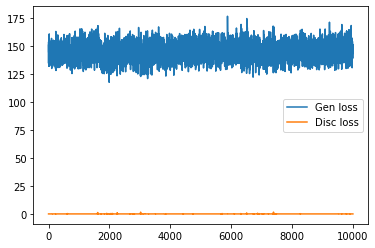

epoch: 46 	 step:0 	 loss: 142.3
epoch: 46 	 step:100 	 loss: 140.9
epoch: 46 	 step:200 	 loss: 134.5
epoch: 46 	 step:300 	 loss: 150.4
epoch: 46 	 step:400 	 loss: 136.6
epoch: 46 	 step:500 	 loss: 144.3
epoch: 46 	 step:600 	 loss: 134.6
epoch: 46 	 step:700 	 loss: 148.1
epoch: 46 	 step:800 	 loss: 144.9
epoch: 46 	 step:900 	 loss: 143.6
epoch: 46 	 step:1000 	 loss: 157.9
epoch: 46 	 step:1100 	 loss: 155.8
epoch: 46 	 step:1200 	 loss: 152.7
epoch: 46 	 step:1300 	 loss: 154.6
epoch: 46 	 step:1400 	 loss: 147.3
epoch: 46 	 step:1500 	 loss: 154.6
epoch: 46 	 step:1600 	 loss: 147.3
epoch: 46 	 step:1700 	 loss: 141.9
epoch: 46 	 step:1800 	 loss: 140.1


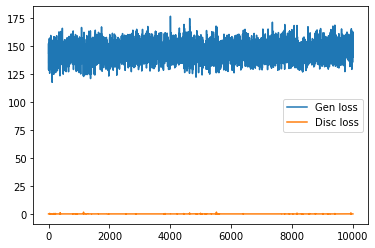

epoch: 47 	 step:0 	 loss: 138.9
epoch: 47 	 step:100 	 loss: 151.4
epoch: 47 	 step:200 	 loss: 160.7
epoch: 47 	 step:300 	 loss: 137.3
epoch: 47 	 step:400 	 loss: 160.0
epoch: 47 	 step:500 	 loss: 152.7
epoch: 47 	 step:600 	 loss: 143.9
epoch: 47 	 step:700 	 loss: 149.5
epoch: 47 	 step:800 	 loss: 143.7
epoch: 47 	 step:900 	 loss: 157.0
epoch: 47 	 step:1000 	 loss: 145.1
epoch: 47 	 step:1100 	 loss: 137.1
epoch: 47 	 step:1200 	 loss: 134.6
epoch: 47 	 step:1300 	 loss: 146.7
epoch: 47 	 step:1400 	 loss: 144.7
epoch: 47 	 step:1500 	 loss: 147.1
epoch: 47 	 step:1600 	 loss: 146.5
epoch: 47 	 step:1700 	 loss: 142.0
epoch: 47 	 step:1800 	 loss: 156.7


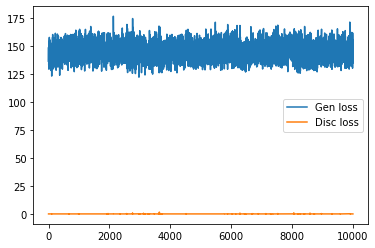

epoch: 48 	 step:0 	 loss: 157.5
epoch: 48 	 step:100 	 loss: 141.8
epoch: 48 	 step:200 	 loss: 143.2
epoch: 48 	 step:300 	 loss: 144.0
epoch: 48 	 step:400 	 loss: 135.2
epoch: 48 	 step:500 	 loss: 144.2
epoch: 48 	 step:600 	 loss: 162.2
epoch: 48 	 step:700 	 loss: 155.0
epoch: 48 	 step:800 	 loss: 141.1
epoch: 48 	 step:900 	 loss: 153.8
epoch: 48 	 step:1000 	 loss: 146.2
epoch: 48 	 step:1100 	 loss: 145.2
epoch: 48 	 step:1200 	 loss: 145.1
epoch: 48 	 step:1300 	 loss: 154.3
epoch: 48 	 step:1400 	 loss: 144.1
epoch: 48 	 step:1500 	 loss: 151.6
epoch: 48 	 step:1600 	 loss: 146.3
epoch: 48 	 step:1700 	 loss: 137.1
epoch: 48 	 step:1800 	 loss: 146.8


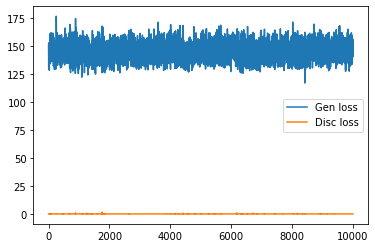

epoch: 49 	 step:0 	 loss: 147.6
epoch: 49 	 step:100 	 loss: 145.9
epoch: 49 	 step:200 	 loss: 154.0
epoch: 49 	 step:300 	 loss: 145.3
epoch: 49 	 step:400 	 loss: 148.6
epoch: 49 	 step:500 	 loss: 154.0
epoch: 49 	 step:600 	 loss: 141.5
epoch: 49 	 step:700 	 loss: 147.1
epoch: 49 	 step:800 	 loss: 145.7
epoch: 49 	 step:900 	 loss: 151.0
epoch: 49 	 step:1000 	 loss: 138.3
epoch: 49 	 step:1100 	 loss: 148.5
epoch: 49 	 step:1200 	 loss: 149.6
epoch: 49 	 step:1300 	 loss: 145.5
epoch: 49 	 step:1400 	 loss: 140.7
epoch: 49 	 step:1500 	 loss: 147.1
epoch: 49 	 step:1600 	 loss: 134.1
epoch: 49 	 step:1700 	 loss: 139.4
epoch: 49 	 step:1800 	 loss: 144.5


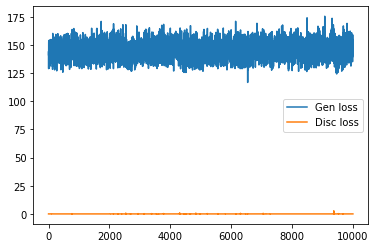

epoch: 50 	 step:0 	 loss: 142.4
epoch: 50 	 step:100 	 loss: 144.6
epoch: 50 	 step:200 	 loss: 152.7
epoch: 50 	 step:300 	 loss: 141.2
epoch: 50 	 step:400 	 loss: 142.0
epoch: 50 	 step:500 	 loss: 143.4
epoch: 50 	 step:600 	 loss: 149.9
epoch: 50 	 step:700 	 loss: 146.5
epoch: 50 	 step:800 	 loss: 144.5
epoch: 50 	 step:900 	 loss: 145.2
epoch: 50 	 step:1000 	 loss: 145.8
epoch: 50 	 step:1100 	 loss: 147.7
epoch: 50 	 step:1200 	 loss: 153.0
epoch: 50 	 step:1300 	 loss: 166.3
epoch: 50 	 step:1400 	 loss: 152.4
epoch: 50 	 step:1500 	 loss: 143.7
epoch: 50 	 step:1600 	 loss: 148.1
epoch: 50 	 step:1700 	 loss: 139.6
epoch: 50 	 step:1800 	 loss: 150.9


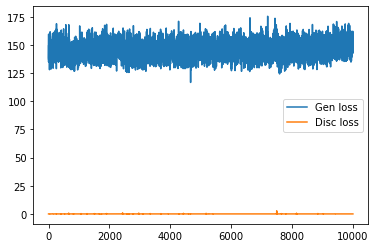

epoch: 51 	 step:0 	 loss: 152.3
epoch: 51 	 step:100 	 loss: 163.7
epoch: 51 	 step:200 	 loss: 146.0
epoch: 51 	 step:300 	 loss: 135.1
epoch: 51 	 step:400 	 loss: 144.2
epoch: 51 	 step:500 	 loss: 139.6
epoch: 51 	 step:600 	 loss: 148.6
epoch: 51 	 step:700 	 loss: 153.5
epoch: 51 	 step:800 	 loss: 132.8
epoch: 51 	 step:900 	 loss: 142.1
epoch: 51 	 step:1000 	 loss: 165.5
epoch: 51 	 step:1100 	 loss: 139.4
epoch: 51 	 step:1200 	 loss: 157.1
epoch: 51 	 step:1300 	 loss: 163.3
epoch: 51 	 step:1400 	 loss: 150.8
epoch: 51 	 step:1500 	 loss: 137.8
epoch: 51 	 step:1600 	 loss: 140.9
epoch: 51 	 step:1700 	 loss: 146.2
epoch: 51 	 step:1800 	 loss: 139.6


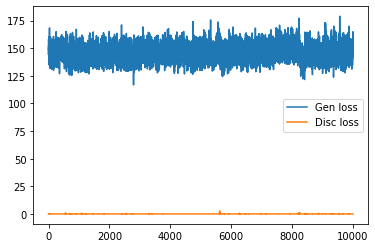

epoch: 52 	 step:0 	 loss: 155.6
epoch: 52 	 step:100 	 loss: 139.9
epoch: 52 	 step:200 	 loss: 153.1
epoch: 52 	 step:300 	 loss: 138.7
epoch: 52 	 step:400 	 loss: 151.1
epoch: 52 	 step:500 	 loss: 152.0
epoch: 52 	 step:600 	 loss: 139.3
epoch: 52 	 step:700 	 loss: 136.7
epoch: 52 	 step:800 	 loss: 140.6
epoch: 52 	 step:900 	 loss: 159.7
epoch: 52 	 step:1000 	 loss: 150.0
epoch: 52 	 step:1100 	 loss: 144.3
epoch: 52 	 step:1200 	 loss: 138.0
epoch: 52 	 step:1300 	 loss: 147.5
epoch: 52 	 step:1400 	 loss: 148.8
epoch: 52 	 step:1500 	 loss: 146.3
epoch: 52 	 step:1600 	 loss: 139.8
epoch: 52 	 step:1700 	 loss: 148.3
epoch: 52 	 step:1800 	 loss: 150.0


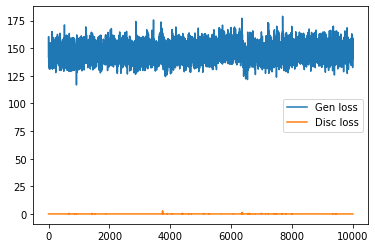

epoch: 53 	 step:0 	 loss: 148.7
epoch: 53 	 step:100 	 loss: 153.8
epoch: 53 	 step:200 	 loss: 144.6
epoch: 53 	 step:300 	 loss: 155.7
epoch: 53 	 step:400 	 loss: 150.9
epoch: 53 	 step:500 	 loss: 139.3
epoch: 53 	 step:600 	 loss: 149.6
epoch: 53 	 step:700 	 loss: 154.6
epoch: 53 	 step:800 	 loss: 146.9
epoch: 53 	 step:900 	 loss: 142.7
epoch: 53 	 step:1000 	 loss: 151.1
epoch: 53 	 step:1100 	 loss: 146.2
epoch: 53 	 step:1200 	 loss: 143.6
epoch: 53 	 step:1300 	 loss: 151.0
epoch: 53 	 step:1400 	 loss: 149.7
epoch: 53 	 step:1500 	 loss: 137.6
epoch: 53 	 step:1600 	 loss: 146.8
epoch: 53 	 step:1700 	 loss: 142.0
epoch: 53 	 step:1800 	 loss: 146.3


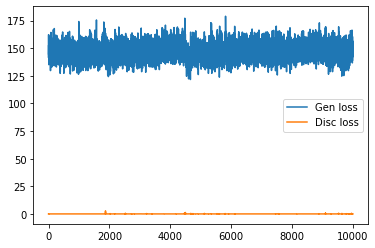

epoch: 54 	 step:0 	 loss: 150.0
epoch: 54 	 step:100 	 loss: 141.1
epoch: 54 	 step:200 	 loss: 137.9
epoch: 54 	 step:300 	 loss: 155.5
epoch: 54 	 step:400 	 loss: 149.9
epoch: 54 	 step:500 	 loss: 149.2
epoch: 54 	 step:600 	 loss: 148.2
epoch: 54 	 step:700 	 loss: 142.3
epoch: 54 	 step:800 	 loss: 137.7
epoch: 54 	 step:900 	 loss: 156.1
epoch: 54 	 step:1000 	 loss: 152.7
epoch: 54 	 step:1100 	 loss: 144.2
epoch: 54 	 step:1200 	 loss: 159.2
epoch: 54 	 step:1300 	 loss: 133.9
epoch: 54 	 step:1400 	 loss: 148.8
epoch: 54 	 step:1500 	 loss: 150.3
epoch: 54 	 step:1600 	 loss: 155.2
epoch: 54 	 step:1700 	 loss: 143.4
epoch: 54 	 step:1800 	 loss: 150.2


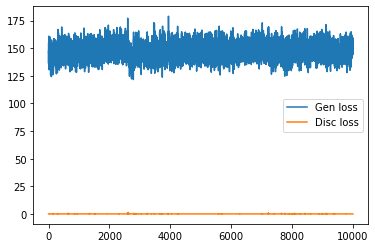

epoch: 55 	 step:0 	 loss: 149.9
epoch: 55 	 step:100 	 loss: 152.6
epoch: 55 	 step:200 	 loss: 151.3
epoch: 55 	 step:300 	 loss: 148.5
epoch: 55 	 step:400 	 loss: 150.1
epoch: 55 	 step:500 	 loss: 146.0
epoch: 55 	 step:600 	 loss: 145.1
epoch: 55 	 step:700 	 loss: 145.7
epoch: 55 	 step:800 	 loss: 153.7
epoch: 55 	 step:900 	 loss: 143.4
epoch: 55 	 step:1000 	 loss: 143.9
epoch: 55 	 step:1100 	 loss: 152.9
epoch: 55 	 step:1200 	 loss: 144.2
epoch: 55 	 step:1300 	 loss: 144.8
epoch: 55 	 step:1400 	 loss: 146.1
epoch: 55 	 step:1500 	 loss: 151.0
epoch: 55 	 step:1600 	 loss: 153.8
epoch: 55 	 step:1700 	 loss: 157.5
epoch: 55 	 step:1800 	 loss: 145.8


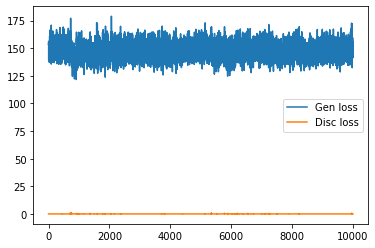

epoch: 56 	 step:0 	 loss: 136.1
epoch: 56 	 step:100 	 loss: 133.2
epoch: 56 	 step:200 	 loss: 125.2
epoch: 56 	 step:300 	 loss: 145.9
epoch: 56 	 step:400 	 loss: 147.9
epoch: 56 	 step:500 	 loss: 155.5
epoch: 56 	 step:600 	 loss: 150.7
epoch: 56 	 step:700 	 loss: 146.2
epoch: 56 	 step:800 	 loss: 143.8
epoch: 56 	 step:900 	 loss: 150.9
epoch: 56 	 step:1000 	 loss: 150.9
epoch: 56 	 step:1100 	 loss: 147.9
epoch: 56 	 step:1200 	 loss: 154.0
epoch: 56 	 step:1300 	 loss: 153.5
epoch: 56 	 step:1400 	 loss: 148.1
epoch: 56 	 step:1500 	 loss: 147.6
epoch: 56 	 step:1600 	 loss: 150.5
epoch: 56 	 step:1700 	 loss: 140.2
epoch: 56 	 step:1800 	 loss: 136.6


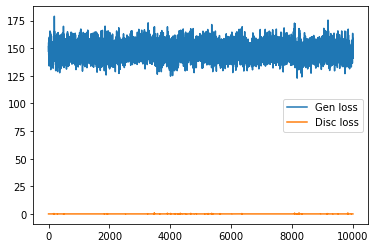

epoch: 57 	 step:0 	 loss: 147.7
epoch: 57 	 step:100 	 loss: 145.2
epoch: 57 	 step:200 	 loss: 142.3
epoch: 57 	 step:300 	 loss: 147.1
epoch: 57 	 step:400 	 loss: 148.8
epoch: 57 	 step:500 	 loss: 142.3
epoch: 57 	 step:600 	 loss: 144.1
epoch: 57 	 step:700 	 loss: 149.5
epoch: 57 	 step:800 	 loss: 142.0
epoch: 57 	 step:900 	 loss: 141.9
epoch: 57 	 step:1000 	 loss: 158.0
epoch: 57 	 step:1100 	 loss: 149.7
epoch: 57 	 step:1200 	 loss: 156.4
epoch: 57 	 step:1300 	 loss: 151.6
epoch: 57 	 step:1400 	 loss: 134.1
epoch: 57 	 step:1500 	 loss: 139.0
epoch: 57 	 step:1600 	 loss: 152.3
epoch: 57 	 step:1700 	 loss: 152.7
epoch: 57 	 step:1800 	 loss: 143.1


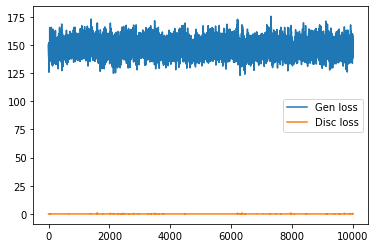

epoch: 58 	 step:0 	 loss: 148.2
epoch: 58 	 step:100 	 loss: 147.0
epoch: 58 	 step:200 	 loss: 137.7
epoch: 58 	 step:300 	 loss: 159.2
epoch: 58 	 step:400 	 loss: 149.1
epoch: 58 	 step:500 	 loss: 146.2
epoch: 58 	 step:600 	 loss: 140.8
epoch: 58 	 step:700 	 loss: 153.6
epoch: 58 	 step:800 	 loss: 145.7
epoch: 58 	 step:900 	 loss: 151.8
epoch: 58 	 step:1000 	 loss: 149.2
epoch: 58 	 step:1100 	 loss: 148.3
epoch: 58 	 step:1200 	 loss: 140.8
epoch: 58 	 step:1300 	 loss: 146.1
epoch: 58 	 step:1400 	 loss: 145.4
epoch: 58 	 step:1500 	 loss: 153.6
epoch: 58 	 step:1600 	 loss: 146.4
epoch: 58 	 step:1700 	 loss: 154.5
epoch: 58 	 step:1800 	 loss: 153.9


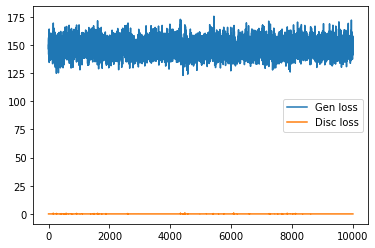

epoch: 59 	 step:0 	 loss: 147.1
epoch: 59 	 step:100 	 loss: 136.9
epoch: 59 	 step:200 	 loss: 151.2
epoch: 59 	 step:300 	 loss: 149.9
epoch: 59 	 step:400 	 loss: 155.6
epoch: 59 	 step:500 	 loss: 138.5
epoch: 59 	 step:600 	 loss: 142.3
epoch: 59 	 step:700 	 loss: 147.2
epoch: 59 	 step:800 	 loss: 137.4
epoch: 59 	 step:900 	 loss: 147.1
epoch: 59 	 step:1000 	 loss: 147.6
epoch: 59 	 step:1100 	 loss: 142.8
epoch: 59 	 step:1200 	 loss: 154.1
epoch: 59 	 step:1300 	 loss: 137.6
epoch: 59 	 step:1400 	 loss: 145.5
epoch: 59 	 step:1500 	 loss: 146.2
epoch: 59 	 step:1600 	 loss: 149.7
epoch: 59 	 step:1700 	 loss: 142.1
epoch: 59 	 step:1800 	 loss: 159.3


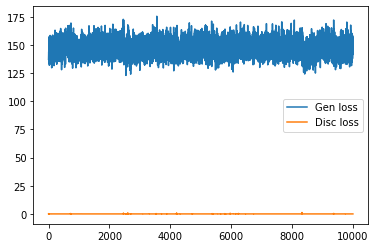

epoch: 60 	 step:0 	 loss: 145.0
epoch: 60 	 step:100 	 loss: 144.4
epoch: 60 	 step:200 	 loss: 146.0
epoch: 60 	 step:300 	 loss: 144.9
epoch: 60 	 step:400 	 loss: 139.4
epoch: 60 	 step:500 	 loss: 137.9
epoch: 60 	 step:600 	 loss: 169.8
epoch: 60 	 step:700 	 loss: 141.5
epoch: 60 	 step:800 	 loss: 159.7
epoch: 60 	 step:900 	 loss: 153.1
epoch: 60 	 step:1000 	 loss: 144.5
epoch: 60 	 step:1100 	 loss: 149.7
epoch: 60 	 step:1200 	 loss: 159.6
epoch: 60 	 step:1300 	 loss: 140.8
epoch: 60 	 step:1400 	 loss: 144.4
epoch: 60 	 step:1500 	 loss: 142.9
epoch: 60 	 step:1600 	 loss: 147.9
epoch: 60 	 step:1700 	 loss: 152.4
epoch: 60 	 step:1800 	 loss: 154.0


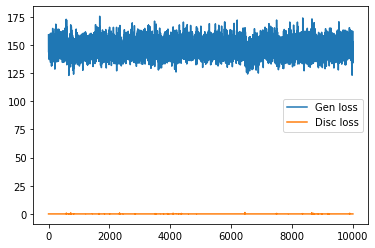

epoch: 61 	 step:0 	 loss: 137.2
epoch: 61 	 step:100 	 loss: 152.6
epoch: 61 	 step:200 	 loss: 150.9
epoch: 61 	 step:300 	 loss: 137.9
epoch: 61 	 step:400 	 loss: 144.0
epoch: 61 	 step:500 	 loss: 146.2
epoch: 61 	 step:600 	 loss: 155.7
epoch: 61 	 step:700 	 loss: 149.3
epoch: 61 	 step:800 	 loss: 163.9
epoch: 61 	 step:900 	 loss: 151.5
epoch: 61 	 step:1000 	 loss: 144.0
epoch: 61 	 step:1100 	 loss: 146.0
epoch: 61 	 step:1200 	 loss: 143.0
epoch: 61 	 step:1300 	 loss: 147.6
epoch: 61 	 step:1400 	 loss: 135.1
epoch: 61 	 step:1500 	 loss: 142.4
epoch: 61 	 step:1600 	 loss: 158.2
epoch: 61 	 step:1700 	 loss: 137.2
epoch: 61 	 step:1800 	 loss: 145.0


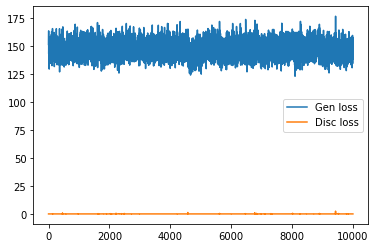

epoch: 62 	 step:0 	 loss: 156.8
epoch: 62 	 step:100 	 loss: 152.6
epoch: 62 	 step:200 	 loss: 152.3
epoch: 62 	 step:300 	 loss: 140.8
epoch: 62 	 step:400 	 loss: 144.3
epoch: 62 	 step:500 	 loss: 143.1
epoch: 62 	 step:600 	 loss: 148.9
epoch: 62 	 step:700 	 loss: 148.2
epoch: 62 	 step:800 	 loss: 152.0
epoch: 62 	 step:900 	 loss: 141.7
epoch: 62 	 step:1000 	 loss: 140.5
epoch: 62 	 step:1100 	 loss: 153.1
epoch: 62 	 step:1200 	 loss: 156.7
epoch: 62 	 step:1300 	 loss: 142.3
epoch: 62 	 step:1400 	 loss: 146.0
epoch: 62 	 step:1500 	 loss: 163.1
epoch: 62 	 step:1600 	 loss: 146.2
epoch: 62 	 step:1700 	 loss: 151.5
epoch: 62 	 step:1800 	 loss: 155.6


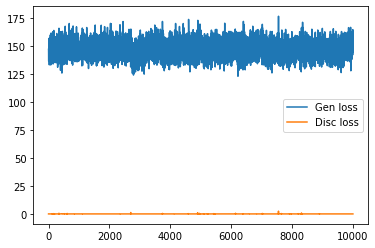

epoch: 63 	 step:0 	 loss: 139.5
epoch: 63 	 step:100 	 loss: 148.5
epoch: 63 	 step:200 	 loss: 151.9
epoch: 63 	 step:300 	 loss: 147.5
epoch: 63 	 step:400 	 loss: 144.4
epoch: 63 	 step:500 	 loss: 137.7
epoch: 63 	 step:600 	 loss: 151.8
epoch: 63 	 step:700 	 loss: 151.3
epoch: 63 	 step:800 	 loss: 150.7
epoch: 63 	 step:900 	 loss: 144.4
epoch: 63 	 step:1000 	 loss: 147.8
epoch: 63 	 step:1100 	 loss: 149.2
epoch: 63 	 step:1200 	 loss: 141.6
epoch: 63 	 step:1300 	 loss: 159.3
epoch: 63 	 step:1400 	 loss: 147.8
epoch: 63 	 step:1500 	 loss: 139.9
epoch: 63 	 step:1600 	 loss: 141.6
epoch: 63 	 step:1700 	 loss: 149.1
epoch: 63 	 step:1800 	 loss: 155.1


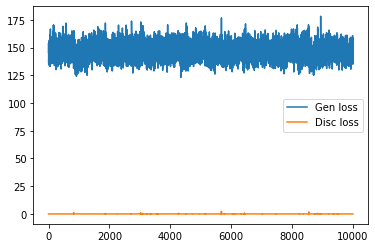

epoch: 64 	 step:0 	 loss: 151.0
epoch: 64 	 step:100 	 loss: 144.0
epoch: 64 	 step:200 	 loss: 147.3
epoch: 64 	 step:300 	 loss: 136.7
epoch: 64 	 step:400 	 loss: 139.1
epoch: 64 	 step:500 	 loss: 155.1
epoch: 64 	 step:600 	 loss: 157.7
epoch: 64 	 step:700 	 loss: 134.9
epoch: 64 	 step:800 	 loss: 142.3
epoch: 64 	 step:900 	 loss: 142.3
epoch: 64 	 step:1000 	 loss: 152.3
epoch: 64 	 step:1100 	 loss: 145.9
epoch: 64 	 step:1200 	 loss: 156.4
epoch: 64 	 step:1300 	 loss: 147.7
epoch: 64 	 step:1400 	 loss: 146.4
epoch: 64 	 step:1500 	 loss: 146.5
epoch: 64 	 step:1600 	 loss: 137.8
epoch: 64 	 step:1700 	 loss: 138.5
epoch: 64 	 step:1800 	 loss: 145.7


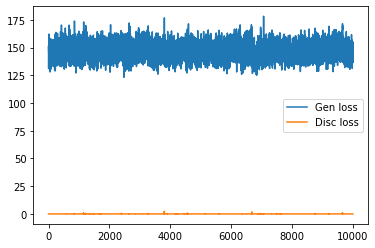

epoch: 65 	 step:0 	 loss: 144.1
epoch: 65 	 step:100 	 loss: 143.1
epoch: 65 	 step:200 	 loss: 156.1
epoch: 65 	 step:300 	 loss: 145.4
epoch: 65 	 step:400 	 loss: 146.1
epoch: 65 	 step:500 	 loss: 148.3
epoch: 65 	 step:600 	 loss: 142.6
epoch: 65 	 step:700 	 loss: 142.9
epoch: 65 	 step:800 	 loss: 145.9
epoch: 65 	 step:900 	 loss: 150.4
epoch: 65 	 step:1000 	 loss: 145.1
epoch: 65 	 step:1100 	 loss: 140.6
epoch: 65 	 step:1200 	 loss: 154.8
epoch: 65 	 step:1300 	 loss: 150.9
epoch: 65 	 step:1400 	 loss: 134.2
epoch: 65 	 step:1500 	 loss: 136.0
epoch: 65 	 step:1600 	 loss: 157.9
epoch: 65 	 step:1700 	 loss: 153.8
epoch: 65 	 step:1800 	 loss: 140.3


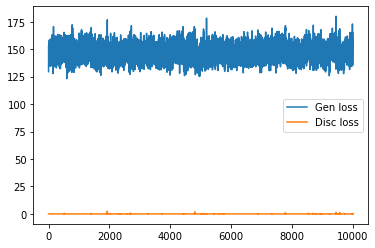

epoch: 66 	 step:0 	 loss: 159.8
epoch: 66 	 step:100 	 loss: 142.0
epoch: 66 	 step:200 	 loss: 147.0
epoch: 66 	 step:300 	 loss: 140.0
epoch: 66 	 step:400 	 loss: 146.8
epoch: 66 	 step:500 	 loss: 155.0
epoch: 66 	 step:600 	 loss: 147.4
epoch: 66 	 step:700 	 loss: 142.9
epoch: 66 	 step:800 	 loss: 151.7
epoch: 66 	 step:900 	 loss: 142.7
epoch: 66 	 step:1000 	 loss: 137.1
epoch: 66 	 step:1100 	 loss: 145.0
epoch: 66 	 step:1200 	 loss: 131.9
epoch: 66 	 step:1300 	 loss: 139.8
epoch: 66 	 step:1400 	 loss: 140.9
epoch: 66 	 step:1500 	 loss: 156.2
epoch: 66 	 step:1600 	 loss: 148.3
epoch: 66 	 step:1700 	 loss: 152.3
epoch: 66 	 step:1800 	 loss: 149.2


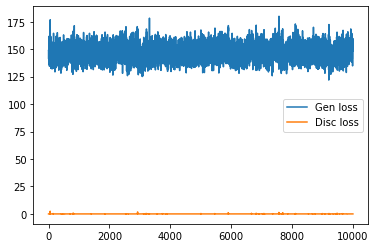

epoch: 67 	 step:0 	 loss: 148.0
epoch: 67 	 step:100 	 loss: 143.9
epoch: 67 	 step:200 	 loss: 152.5
epoch: 67 	 step:300 	 loss: 138.7
epoch: 67 	 step:400 	 loss: 151.2
epoch: 67 	 step:500 	 loss: 147.9
epoch: 67 	 step:600 	 loss: 146.7
epoch: 67 	 step:700 	 loss: 138.6
epoch: 67 	 step:800 	 loss: 157.3
epoch: 67 	 step:900 	 loss: 146.8
epoch: 67 	 step:1000 	 loss: 159.1
epoch: 67 	 step:1100 	 loss: 150.1
epoch: 67 	 step:1200 	 loss: 150.8
epoch: 67 	 step:1300 	 loss: 133.8
epoch: 67 	 step:1400 	 loss: 149.8
epoch: 67 	 step:1500 	 loss: 144.2
epoch: 67 	 step:1600 	 loss: 152.6
epoch: 67 	 step:1700 	 loss: 156.6
epoch: 67 	 step:1800 	 loss: 145.5


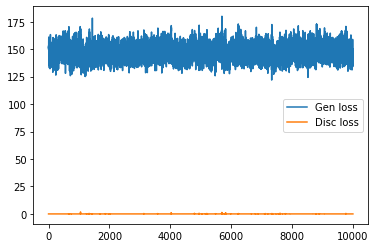

epoch: 68 	 step:0 	 loss: 145.1
epoch: 68 	 step:100 	 loss: 148.9
epoch: 68 	 step:200 	 loss: 146.2
epoch: 68 	 step:300 	 loss: 153.1
epoch: 68 	 step:400 	 loss: 155.7
epoch: 68 	 step:500 	 loss: 142.6
epoch: 68 	 step:600 	 loss: 134.3
epoch: 68 	 step:700 	 loss: 143.6
epoch: 68 	 step:800 	 loss: 136.3
epoch: 68 	 step:900 	 loss: 141.5
epoch: 68 	 step:1000 	 loss: 151.2
epoch: 68 	 step:1100 	 loss: 147.6
epoch: 68 	 step:1200 	 loss: 147.6
epoch: 68 	 step:1300 	 loss: 148.8
epoch: 68 	 step:1400 	 loss: 145.2
epoch: 68 	 step:1500 	 loss: 155.5
epoch: 68 	 step:1600 	 loss: 150.0
epoch: 68 	 step:1700 	 loss: 152.6
epoch: 68 	 step:1800 	 loss: 151.7


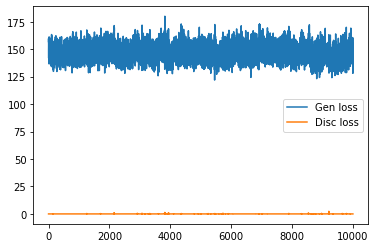

epoch: 69 	 step:0 	 loss: 147.4
epoch: 69 	 step:100 	 loss: 145.8
epoch: 69 	 step:200 	 loss: 151.2
epoch: 69 	 step:300 	 loss: 143.9
epoch: 69 	 step:400 	 loss: 146.1
epoch: 69 	 step:500 	 loss: 143.8
epoch: 69 	 step:600 	 loss: 151.8
epoch: 69 	 step:700 	 loss: 154.6
epoch: 69 	 step:800 	 loss: 150.3
epoch: 69 	 step:900 	 loss: 140.0
epoch: 69 	 step:1000 	 loss: 152.7
epoch: 69 	 step:1100 	 loss: 152.3
epoch: 69 	 step:1200 	 loss: 142.1
epoch: 69 	 step:1300 	 loss: 161.5
epoch: 69 	 step:1400 	 loss: 165.9
epoch: 69 	 step:1500 	 loss: 144.2
epoch: 69 	 step:1600 	 loss: 148.9
epoch: 69 	 step:1700 	 loss: 158.3
epoch: 69 	 step:1800 	 loss: 146.3


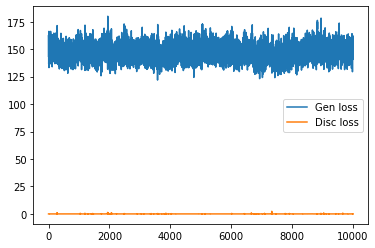

epoch: 70 	 step:0 	 loss: 142.0
epoch: 70 	 step:100 	 loss: 154.3
epoch: 70 	 step:200 	 loss: 145.8
epoch: 70 	 step:300 	 loss: 145.2
epoch: 70 	 step:400 	 loss: 145.9
epoch: 70 	 step:500 	 loss: 165.5
epoch: 70 	 step:600 	 loss: 145.5
epoch: 70 	 step:700 	 loss: 143.7
epoch: 70 	 step:800 	 loss: 137.4
epoch: 70 	 step:900 	 loss: 171.0
epoch: 70 	 step:1000 	 loss: 151.5
epoch: 70 	 step:1100 	 loss: 146.7
epoch: 70 	 step:1200 	 loss: 149.4
epoch: 70 	 step:1300 	 loss: 154.0
epoch: 70 	 step:1400 	 loss: 146.6
epoch: 70 	 step:1500 	 loss: 153.8
epoch: 70 	 step:1600 	 loss: 143.3
epoch: 70 	 step:1700 	 loss: 146.7
epoch: 70 	 step:1800 	 loss: 152.8


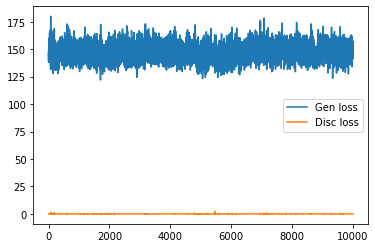

epoch: 71 	 step:0 	 loss: 145.1
epoch: 71 	 step:100 	 loss: 141.1
epoch: 71 	 step:200 	 loss: 135.7
epoch: 71 	 step:300 	 loss: 156.9
epoch: 71 	 step:400 	 loss: 150.4
epoch: 71 	 step:500 	 loss: 148.8
epoch: 71 	 step:600 	 loss: 166.0
epoch: 71 	 step:700 	 loss: 139.8
epoch: 71 	 step:800 	 loss: 154.7
epoch: 71 	 step:900 	 loss: 163.0
epoch: 71 	 step:1000 	 loss: 137.8
epoch: 71 	 step:1100 	 loss: 148.9
epoch: 71 	 step:1200 	 loss: 151.8
epoch: 71 	 step:1300 	 loss: 145.4
epoch: 71 	 step:1400 	 loss: 146.6
epoch: 71 	 step:1500 	 loss: 149.7
epoch: 71 	 step:1600 	 loss: 159.2
epoch: 71 	 step:1700 	 loss: 146.9
epoch: 71 	 step:1800 	 loss: 148.5


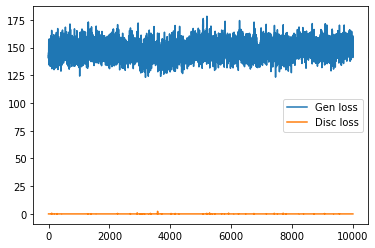

epoch: 72 	 step:0 	 loss: 151.7
epoch: 72 	 step:100 	 loss: 156.2
epoch: 72 	 step:200 	 loss: 137.0
epoch: 72 	 step:300 	 loss: 136.7
epoch: 72 	 step:400 	 loss: 133.4
epoch: 72 	 step:500 	 loss: 140.4
epoch: 72 	 step:600 	 loss: 147.9
epoch: 72 	 step:700 	 loss: 157.1
epoch: 72 	 step:800 	 loss: 131.1
epoch: 72 	 step:900 	 loss: 144.8
epoch: 72 	 step:1000 	 loss: 147.1
epoch: 72 	 step:1100 	 loss: 146.6
epoch: 72 	 step:1200 	 loss: 148.3
epoch: 72 	 step:1300 	 loss: 150.1
epoch: 72 	 step:1400 	 loss: 139.7
epoch: 72 	 step:1500 	 loss: 144.4
epoch: 72 	 step:1600 	 loss: 147.5
epoch: 72 	 step:1700 	 loss: 141.3
epoch: 72 	 step:1800 	 loss: 137.9


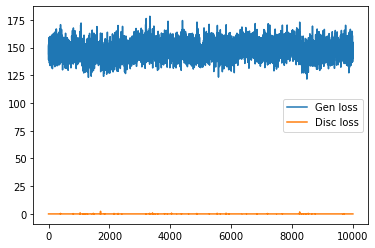

epoch: 73 	 step:0 	 loss: 141.3
epoch: 73 	 step:100 	 loss: 144.5
epoch: 73 	 step:200 	 loss: 155.3
epoch: 73 	 step:300 	 loss: 159.2
epoch: 73 	 step:400 	 loss: 149.3
epoch: 73 	 step:500 	 loss: 150.9
epoch: 73 	 step:600 	 loss: 160.3
epoch: 73 	 step:700 	 loss: 149.3
epoch: 73 	 step:800 	 loss: 144.2
epoch: 73 	 step:900 	 loss: 151.0
epoch: 73 	 step:1000 	 loss: 148.5
epoch: 73 	 step:1100 	 loss: 142.7
epoch: 73 	 step:1200 	 loss: 150.2
epoch: 73 	 step:1300 	 loss: 149.6
epoch: 73 	 step:1400 	 loss: 148.7
epoch: 73 	 step:1500 	 loss: 162.2
epoch: 73 	 step:1600 	 loss: 139.1
epoch: 73 	 step:1700 	 loss: 134.5
epoch: 73 	 step:1800 	 loss: 148.9


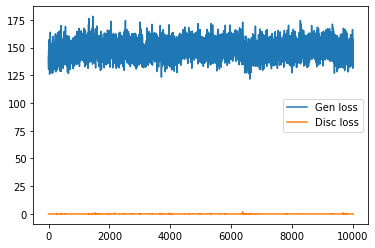

epoch: 74 	 step:0 	 loss: 136.3
epoch: 74 	 step:100 	 loss: 152.5
epoch: 74 	 step:200 	 loss: 162.8
epoch: 74 	 step:300 	 loss: 147.3
epoch: 74 	 step:400 	 loss: 147.0
epoch: 74 	 step:500 	 loss: 138.1
epoch: 74 	 step:600 	 loss: 147.5
epoch: 74 	 step:700 	 loss: 144.5
epoch: 74 	 step:800 	 loss: 145.7
epoch: 74 	 step:900 	 loss: 145.3
epoch: 74 	 step:1000 	 loss: 142.9
epoch: 74 	 step:1100 	 loss: 162.6
epoch: 74 	 step:1200 	 loss: 143.6
epoch: 74 	 step:1300 	 loss: 149.4
epoch: 74 	 step:1400 	 loss: 158.5
epoch: 74 	 step:1500 	 loss: 142.0
epoch: 74 	 step:1600 	 loss: 136.7
epoch: 74 	 step:1700 	 loss: 137.2
epoch: 74 	 step:1800 	 loss: 154.5


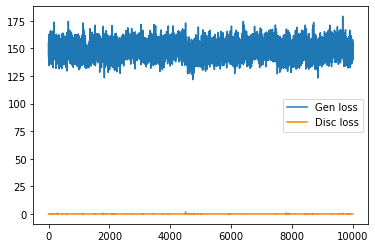

epoch: 75 	 step:0 	 loss: 146.3
epoch: 75 	 step:100 	 loss: 154.7
epoch: 75 	 step:200 	 loss: 154.1
epoch: 75 	 step:300 	 loss: 149.6
epoch: 75 	 step:400 	 loss: 137.4
epoch: 75 	 step:500 	 loss: 148.1
epoch: 75 	 step:600 	 loss: 143.7
epoch: 75 	 step:700 	 loss: 143.1
epoch: 75 	 step:800 	 loss: 150.1
epoch: 75 	 step:900 	 loss: 150.5
epoch: 75 	 step:1000 	 loss: 148.3
epoch: 75 	 step:1100 	 loss: 157.7
epoch: 75 	 step:1200 	 loss: 152.2
epoch: 75 	 step:1300 	 loss: 150.6
epoch: 75 	 step:1400 	 loss: 151.1
epoch: 75 	 step:1500 	 loss: 139.1
epoch: 75 	 step:1600 	 loss: 148.6
epoch: 75 	 step:1700 	 loss: 154.3
epoch: 75 	 step:1800 	 loss: 158.1


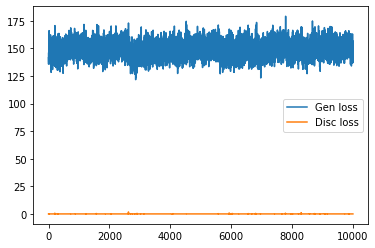

epoch: 76 	 step:0 	 loss: 147.0
epoch: 76 	 step:100 	 loss: 152.4
epoch: 76 	 step:200 	 loss: 149.0
epoch: 76 	 step:300 	 loss: 142.7
epoch: 76 	 step:400 	 loss: 155.8
epoch: 76 	 step:500 	 loss: 149.8
epoch: 76 	 step:600 	 loss: 143.8
epoch: 76 	 step:700 	 loss: 143.4
epoch: 76 	 step:800 	 loss: 150.4
epoch: 76 	 step:900 	 loss: 139.1
epoch: 76 	 step:1000 	 loss: 148.2
epoch: 76 	 step:1100 	 loss: 152.2
epoch: 76 	 step:1200 	 loss: 152.2
epoch: 76 	 step:1300 	 loss: 153.3
epoch: 76 	 step:1400 	 loss: 146.6
epoch: 76 	 step:1500 	 loss: 144.6
epoch: 76 	 step:1600 	 loss: 149.1
epoch: 76 	 step:1700 	 loss: 143.4
epoch: 76 	 step:1800 	 loss: 148.0


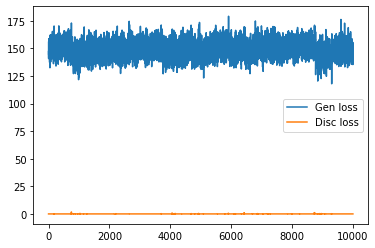

epoch: 77 	 step:0 	 loss: 143.9
epoch: 77 	 step:100 	 loss: 156.4
epoch: 77 	 step:200 	 loss: 144.9
epoch: 77 	 step:300 	 loss: 153.8
epoch: 77 	 step:400 	 loss: 138.1
epoch: 77 	 step:500 	 loss: 154.3
epoch: 77 	 step:600 	 loss: 157.1
epoch: 77 	 step:700 	 loss: 155.4
epoch: 77 	 step:800 	 loss: 140.5
epoch: 77 	 step:900 	 loss: 152.6
epoch: 77 	 step:1000 	 loss: 136.1
epoch: 77 	 step:1100 	 loss: 155.9
epoch: 77 	 step:1200 	 loss: 162.0
epoch: 77 	 step:1300 	 loss: 145.0
epoch: 77 	 step:1400 	 loss: 145.0
epoch: 77 	 step:1500 	 loss: 161.6
epoch: 77 	 step:1600 	 loss: 147.0
epoch: 77 	 step:1700 	 loss: 150.8
epoch: 77 	 step:1800 	 loss: 145.6


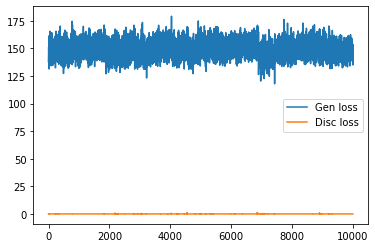

epoch: 78 	 step:0 	 loss: 147.3
epoch: 78 	 step:100 	 loss: 151.6
epoch: 78 	 step:200 	 loss: 146.9
epoch: 78 	 step:300 	 loss: 149.3
epoch: 78 	 step:400 	 loss: 138.5
epoch: 78 	 step:500 	 loss: 150.5
epoch: 78 	 step:600 	 loss: 149.5
epoch: 78 	 step:700 	 loss: 151.4
epoch: 78 	 step:800 	 loss: 130.6
epoch: 78 	 step:900 	 loss: 149.2
epoch: 78 	 step:1000 	 loss: 146.1
epoch: 78 	 step:1100 	 loss: 155.4
epoch: 78 	 step:1200 	 loss: 139.2
epoch: 78 	 step:1300 	 loss: 138.5
epoch: 78 	 step:1400 	 loss: 141.2
epoch: 78 	 step:1500 	 loss: 149.7
epoch: 78 	 step:1600 	 loss: 147.8
epoch: 78 	 step:1700 	 loss: 151.5
epoch: 78 	 step:1800 	 loss: 150.9


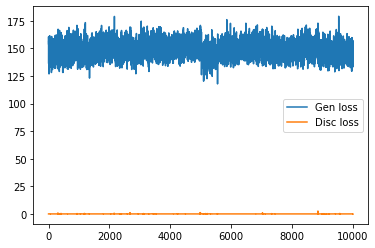

epoch: 79 	 step:0 	 loss: 148.9
epoch: 79 	 step:100 	 loss: 150.3
epoch: 79 	 step:200 	 loss: 152.9
epoch: 79 	 step:300 	 loss: 157.9
epoch: 79 	 step:400 	 loss: 153.7
epoch: 79 	 step:500 	 loss: 145.6
epoch: 79 	 step:600 	 loss: 151.2
epoch: 79 	 step:700 	 loss: 154.1
epoch: 79 	 step:800 	 loss: 140.7
epoch: 79 	 step:900 	 loss: 160.5
epoch: 79 	 step:1000 	 loss: 143.3
epoch: 79 	 step:1100 	 loss: 155.4
epoch: 79 	 step:1200 	 loss: 152.5
epoch: 79 	 step:1300 	 loss: 151.3
epoch: 79 	 step:1400 	 loss: 150.3
epoch: 79 	 step:1500 	 loss: 156.7
epoch: 79 	 step:1600 	 loss: 163.3
epoch: 79 	 step:1700 	 loss: 146.9
epoch: 79 	 step:1800 	 loss: 158.3


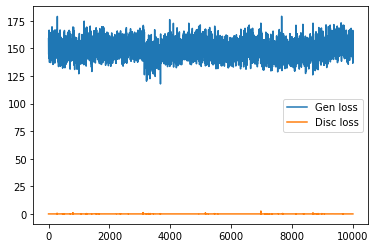

epoch: 80 	 step:0 	 loss: 157.7
epoch: 80 	 step:100 	 loss: 167.2
epoch: 80 	 step:200 	 loss: 151.0
epoch: 80 	 step:300 	 loss: 146.1
epoch: 80 	 step:400 	 loss: 153.9
epoch: 80 	 step:500 	 loss: 148.6
epoch: 80 	 step:600 	 loss: 138.4
epoch: 80 	 step:700 	 loss: 139.5
epoch: 80 	 step:800 	 loss: 153.8
epoch: 80 	 step:900 	 loss: 132.7
epoch: 80 	 step:1000 	 loss: 162.5
epoch: 80 	 step:1100 	 loss: 153.4
epoch: 80 	 step:1200 	 loss: 149.0
epoch: 80 	 step:1300 	 loss: 142.5
epoch: 80 	 step:1400 	 loss: 154.7
epoch: 80 	 step:1500 	 loss: 154.9
epoch: 80 	 step:1600 	 loss: 148.0
epoch: 80 	 step:1700 	 loss: 156.3
epoch: 80 	 step:1800 	 loss: 151.5


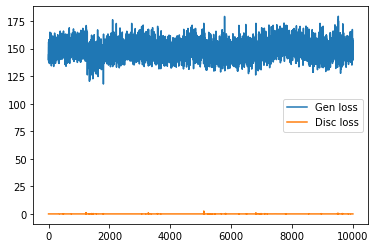

epoch: 81 	 step:0 	 loss: 153.1
epoch: 81 	 step:100 	 loss: 163.3
epoch: 81 	 step:200 	 loss: 146.2
epoch: 81 	 step:300 	 loss: 160.1
epoch: 81 	 step:400 	 loss: 157.7
epoch: 81 	 step:500 	 loss: 144.2
epoch: 81 	 step:600 	 loss: 162.8
epoch: 81 	 step:700 	 loss: 147.7
epoch: 81 	 step:800 	 loss: 139.7
epoch: 81 	 step:900 	 loss: 146.2
epoch: 81 	 step:1000 	 loss: 151.7
epoch: 81 	 step:1100 	 loss: 151.8
epoch: 81 	 step:1200 	 loss: 145.8
epoch: 81 	 step:1300 	 loss: 148.7
epoch: 81 	 step:1400 	 loss: 155.3
epoch: 81 	 step:1500 	 loss: 152.0
epoch: 81 	 step:1600 	 loss: 151.9
epoch: 81 	 step:1700 	 loss: 158.0
epoch: 81 	 step:1800 	 loss: 156.3


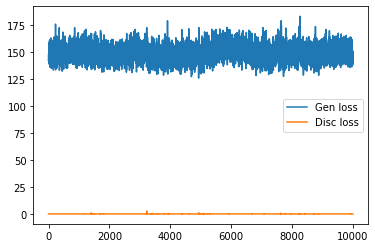

epoch: 82 	 step:0 	 loss: 161.0
epoch: 82 	 step:100 	 loss: 148.7
epoch: 82 	 step:200 	 loss: 142.4
epoch: 82 	 step:300 	 loss: 155.4
epoch: 82 	 step:400 	 loss: 156.7
epoch: 82 	 step:500 	 loss: 147.4
epoch: 82 	 step:600 	 loss: 144.6
epoch: 82 	 step:700 	 loss: 149.0
epoch: 82 	 step:800 	 loss: 141.7
epoch: 82 	 step:900 	 loss: 145.7
epoch: 82 	 step:1000 	 loss: 145.0
epoch: 82 	 step:1100 	 loss: 141.7
epoch: 82 	 step:1200 	 loss: 149.6
epoch: 82 	 step:1300 	 loss: 155.3
epoch: 82 	 step:1400 	 loss: 159.7
epoch: 82 	 step:1500 	 loss: 163.7
epoch: 82 	 step:1600 	 loss: 150.0
epoch: 82 	 step:1700 	 loss: 153.4
epoch: 82 	 step:1800 	 loss: 142.8


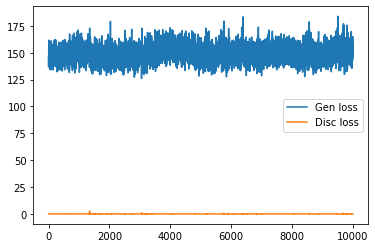

epoch: 83 	 step:0 	 loss: 158.6
epoch: 83 	 step:100 	 loss: 155.0
epoch: 83 	 step:200 	 loss: 129.6
epoch: 83 	 step:300 	 loss: 156.4
epoch: 83 	 step:400 	 loss: 145.2
epoch: 83 	 step:500 	 loss: 151.0
epoch: 83 	 step:600 	 loss: 149.4
epoch: 83 	 step:700 	 loss: 166.1
epoch: 83 	 step:800 	 loss: 149.4
epoch: 83 	 step:900 	 loss: 147.0
epoch: 83 	 step:1000 	 loss: 145.2
epoch: 83 	 step:1100 	 loss: 133.7
epoch: 83 	 step:1200 	 loss: 143.9
epoch: 83 	 step:1300 	 loss: 150.9
epoch: 83 	 step:1400 	 loss: 147.0
epoch: 83 	 step:1500 	 loss: 144.0
epoch: 83 	 step:1600 	 loss: 148.8
epoch: 83 	 step:1700 	 loss: 149.6
epoch: 83 	 step:1800 	 loss: 166.8


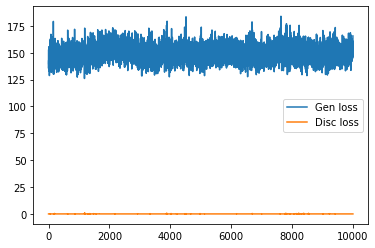

epoch: 84 	 step:0 	 loss: 147.2
epoch: 84 	 step:100 	 loss: 151.6
epoch: 84 	 step:200 	 loss: 158.2
epoch: 84 	 step:300 	 loss: 161.1
epoch: 84 	 step:400 	 loss: 157.8
epoch: 84 	 step:500 	 loss: 158.4
epoch: 84 	 step:600 	 loss: 158.7
epoch: 84 	 step:700 	 loss: 152.8
epoch: 84 	 step:800 	 loss: 163.7
epoch: 84 	 step:900 	 loss: 148.8
epoch: 84 	 step:1000 	 loss: 150.0
epoch: 84 	 step:1100 	 loss: 161.1
epoch: 84 	 step:1200 	 loss: 152.7
epoch: 84 	 step:1300 	 loss: 151.4
epoch: 84 	 step:1400 	 loss: 151.5
epoch: 84 	 step:1500 	 loss: 150.1
epoch: 84 	 step:1600 	 loss: 152.5
epoch: 84 	 step:1700 	 loss: 139.5
epoch: 84 	 step:1800 	 loss: 156.0


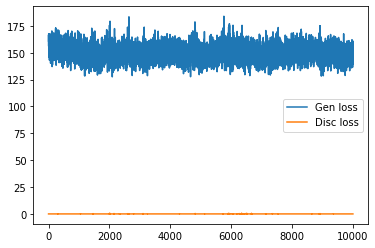

epoch: 85 	 step:0 	 loss: 153.9
epoch: 85 	 step:100 	 loss: 153.9
epoch: 85 	 step:200 	 loss: 154.0
epoch: 85 	 step:300 	 loss: 142.9
epoch: 85 	 step:400 	 loss: 145.0
epoch: 85 	 step:500 	 loss: 145.0
epoch: 85 	 step:600 	 loss: 151.0
epoch: 85 	 step:700 	 loss: 156.0
epoch: 85 	 step:800 	 loss: 147.2
epoch: 85 	 step:900 	 loss: 156.8
epoch: 85 	 step:1000 	 loss: 142.2
epoch: 85 	 step:1100 	 loss: 142.5
epoch: 85 	 step:1200 	 loss: 145.0
epoch: 85 	 step:1300 	 loss: 151.4
epoch: 85 	 step:1400 	 loss: 157.5
epoch: 85 	 step:1500 	 loss: 154.1
epoch: 85 	 step:1600 	 loss: 157.5
epoch: 85 	 step:1700 	 loss: 160.9
epoch: 85 	 step:1800 	 loss: 146.6


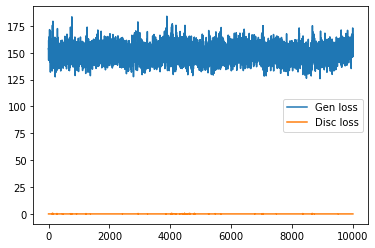

epoch: 86 	 step:0 	 loss: 154.5
epoch: 86 	 step:100 	 loss: 146.4
epoch: 86 	 step:200 	 loss: 154.6
epoch: 86 	 step:300 	 loss: 147.8
epoch: 86 	 step:400 	 loss: 151.1
epoch: 86 	 step:500 	 loss: 151.5
epoch: 86 	 step:600 	 loss: 145.7
epoch: 86 	 step:700 	 loss: 140.5
epoch: 86 	 step:800 	 loss: 151.8
epoch: 86 	 step:900 	 loss: 143.9
epoch: 86 	 step:1000 	 loss: 148.0
epoch: 86 	 step:1100 	 loss: 159.2
epoch: 86 	 step:1200 	 loss: 150.4
epoch: 86 	 step:1300 	 loss: 145.5
epoch: 86 	 step:1400 	 loss: 157.0
epoch: 86 	 step:1500 	 loss: 161.7
epoch: 86 	 step:1600 	 loss: 159.4
epoch: 86 	 step:1700 	 loss: 154.8
epoch: 86 	 step:1800 	 loss: 153.5


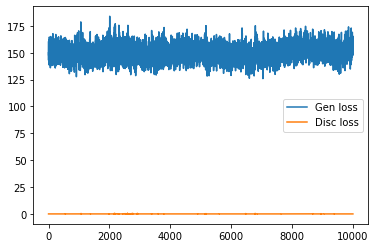

epoch: 87 	 step:0 	 loss: 155.0
epoch: 87 	 step:100 	 loss: 141.6
epoch: 87 	 step:200 	 loss: 146.7
epoch: 87 	 step:300 	 loss: 154.0
epoch: 87 	 step:400 	 loss: 161.7
epoch: 87 	 step:500 	 loss: 156.0
epoch: 87 	 step:600 	 loss: 136.8
epoch: 87 	 step:700 	 loss: 152.4
epoch: 87 	 step:800 	 loss: 152.9
epoch: 87 	 step:900 	 loss: 153.6
epoch: 87 	 step:1000 	 loss: 145.9
epoch: 87 	 step:1100 	 loss: 151.5
epoch: 87 	 step:1200 	 loss: 146.5
epoch: 87 	 step:1300 	 loss: 138.4
epoch: 87 	 step:1400 	 loss: 154.4
epoch: 87 	 step:1500 	 loss: 161.9
epoch: 87 	 step:1600 	 loss: 152.4
epoch: 87 	 step:1700 	 loss: 153.4
epoch: 87 	 step:1800 	 loss: 151.1


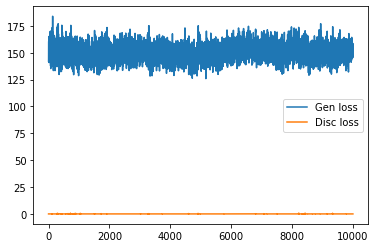

epoch: 88 	 step:0 	 loss: 163.6
epoch: 88 	 step:100 	 loss: 144.8
epoch: 88 	 step:200 	 loss: 151.9
epoch: 88 	 step:300 	 loss: 154.4
epoch: 88 	 step:400 	 loss: 154.3
epoch: 88 	 step:500 	 loss: 164.8
epoch: 88 	 step:600 	 loss: 157.9
epoch: 88 	 step:700 	 loss: 151.3
epoch: 88 	 step:800 	 loss: 153.6
epoch: 88 	 step:900 	 loss: 152.3
epoch: 88 	 step:1000 	 loss: 158.2
epoch: 88 	 step:1100 	 loss: 153.2
epoch: 88 	 step:1200 	 loss: 163.5
epoch: 88 	 step:1300 	 loss: 153.6
epoch: 88 	 step:1400 	 loss: 144.3
epoch: 88 	 step:1500 	 loss: 147.9
epoch: 88 	 step:1600 	 loss: 151.1
epoch: 88 	 step:1700 	 loss: 156.7
epoch: 88 	 step:1800 	 loss: 155.9


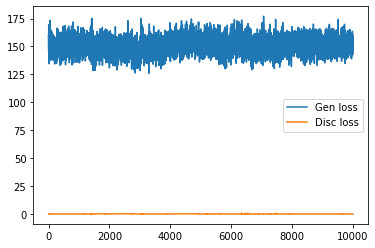

epoch: 89 	 step:0 	 loss: 155.0
epoch: 89 	 step:100 	 loss: 141.7
epoch: 89 	 step:200 	 loss: 144.8
epoch: 89 	 step:300 	 loss: 141.9
epoch: 89 	 step:400 	 loss: 147.6
epoch: 89 	 step:500 	 loss: 146.4
epoch: 89 	 step:600 	 loss: 143.7
epoch: 89 	 step:700 	 loss: 152.7
epoch: 89 	 step:800 	 loss: 159.9
epoch: 89 	 step:900 	 loss: 152.4
epoch: 89 	 step:1000 	 loss: 160.4
epoch: 89 	 step:1100 	 loss: 152.0
epoch: 89 	 step:1200 	 loss: 154.2
epoch: 89 	 step:1300 	 loss: 140.5
epoch: 89 	 step:1400 	 loss: 153.8
epoch: 89 	 step:1500 	 loss: 162.1
epoch: 89 	 step:1600 	 loss: 151.4
epoch: 89 	 step:1700 	 loss: 154.4
epoch: 89 	 step:1800 	 loss: 153.2


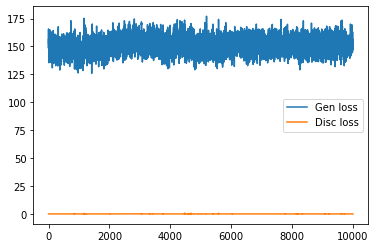

epoch: 90 	 step:0 	 loss: 147.9
epoch: 90 	 step:100 	 loss: 162.5
epoch: 90 	 step:200 	 loss: 143.2
epoch: 90 	 step:300 	 loss: 154.2
epoch: 90 	 step:400 	 loss: 151.6
epoch: 90 	 step:500 	 loss: 146.7
epoch: 90 	 step:600 	 loss: 154.4
epoch: 90 	 step:700 	 loss: 152.6
epoch: 90 	 step:800 	 loss: 140.5
epoch: 90 	 step:900 	 loss: 164.5
epoch: 90 	 step:1000 	 loss: 152.5
epoch: 90 	 step:1100 	 loss: 154.6
epoch: 90 	 step:1200 	 loss: 146.4
epoch: 90 	 step:1300 	 loss: 159.7
epoch: 90 	 step:1400 	 loss: 150.9
epoch: 90 	 step:1500 	 loss: 155.6
epoch: 90 	 step:1600 	 loss: 143.5
epoch: 90 	 step:1700 	 loss: 147.2
epoch: 90 	 step:1800 	 loss: 140.4


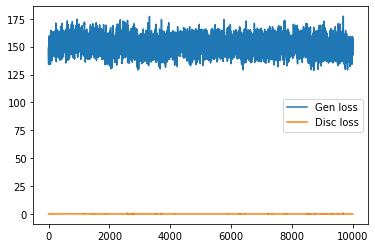

epoch: 91 	 step:0 	 loss: 147.4
epoch: 91 	 step:100 	 loss: 130.0
epoch: 91 	 step:200 	 loss: 153.2
epoch: 91 	 step:300 	 loss: 145.5
epoch: 91 	 step:400 	 loss: 144.3
epoch: 91 	 step:500 	 loss: 140.0
epoch: 91 	 step:600 	 loss: 146.6
epoch: 91 	 step:700 	 loss: 136.2
epoch: 91 	 step:800 	 loss: 157.8
epoch: 91 	 step:900 	 loss: 147.5
epoch: 91 	 step:1000 	 loss: 151.2
epoch: 91 	 step:1100 	 loss: 149.6
epoch: 91 	 step:1200 	 loss: 146.2
epoch: 91 	 step:1300 	 loss: 159.7
epoch: 91 	 step:1400 	 loss: 156.0
epoch: 91 	 step:1500 	 loss: 159.7
epoch: 91 	 step:1600 	 loss: 152.6
epoch: 91 	 step:1700 	 loss: 152.6
epoch: 91 	 step:1800 	 loss: 153.3


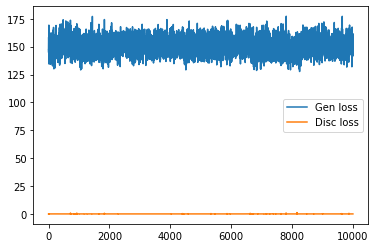

epoch: 92 	 step:0 	 loss: 147.2
epoch: 92 	 step:100 	 loss: 156.7
epoch: 92 	 step:200 	 loss: 143.1
epoch: 92 	 step:300 	 loss: 160.5
epoch: 92 	 step:400 	 loss: 148.1
epoch: 92 	 step:500 	 loss: 148.9
epoch: 92 	 step:600 	 loss: 162.4
epoch: 92 	 step:700 	 loss: 144.9
epoch: 92 	 step:800 	 loss: 161.7
epoch: 92 	 step:900 	 loss: 140.2
epoch: 92 	 step:1000 	 loss: 155.1
epoch: 92 	 step:1100 	 loss: 152.2
epoch: 92 	 step:1200 	 loss: 155.3
epoch: 92 	 step:1300 	 loss: 147.3
epoch: 92 	 step:1400 	 loss: 141.2
epoch: 92 	 step:1500 	 loss: 147.8
epoch: 92 	 step:1600 	 loss: 146.1
epoch: 92 	 step:1700 	 loss: 148.7
epoch: 92 	 step:1800 	 loss: 147.4


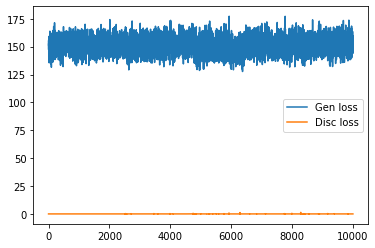

epoch: 93 	 step:0 	 loss: 152.9
epoch: 93 	 step:100 	 loss: 155.7
epoch: 93 	 step:200 	 loss: 148.9
epoch: 93 	 step:300 	 loss: 158.6
epoch: 93 	 step:400 	 loss: 173.1
epoch: 93 	 step:500 	 loss: 163.5
epoch: 93 	 step:600 	 loss: 161.5
epoch: 93 	 step:700 	 loss: 155.8
epoch: 93 	 step:800 	 loss: 150.1
epoch: 93 	 step:900 	 loss: 146.7
epoch: 93 	 step:1000 	 loss: 154.9
epoch: 93 	 step:1100 	 loss: 148.3
epoch: 93 	 step:1200 	 loss: 154.4
epoch: 93 	 step:1300 	 loss: 155.2
epoch: 93 	 step:1400 	 loss: 153.0
epoch: 93 	 step:1500 	 loss: 143.1
epoch: 93 	 step:1600 	 loss: 152.7
epoch: 93 	 step:1700 	 loss: 164.4
epoch: 93 	 step:1800 	 loss: 157.7


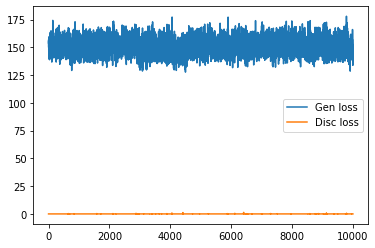

epoch: 94 	 step:0 	 loss: 150.1
epoch: 94 	 step:100 	 loss: 151.2
epoch: 94 	 step:200 	 loss: 142.1
epoch: 94 	 step:300 	 loss: 149.3
epoch: 94 	 step:400 	 loss: 156.5
epoch: 94 	 step:500 	 loss: 155.3
epoch: 94 	 step:600 	 loss: 140.0
epoch: 94 	 step:700 	 loss: 154.5
epoch: 94 	 step:800 	 loss: 148.1
epoch: 94 	 step:900 	 loss: 157.7
epoch: 94 	 step:1000 	 loss: 151.0
epoch: 94 	 step:1100 	 loss: 152.8
epoch: 94 	 step:1200 	 loss: 150.2
epoch: 94 	 step:1300 	 loss: 149.2
epoch: 94 	 step:1400 	 loss: 159.1
epoch: 94 	 step:1500 	 loss: 129.1
epoch: 94 	 step:1600 	 loss: 139.3
epoch: 94 	 step:1700 	 loss: 149.3
epoch: 94 	 step:1800 	 loss: 164.8


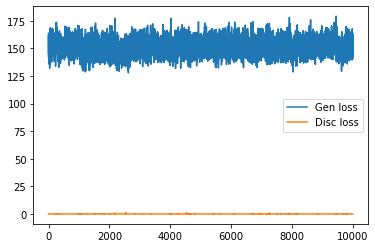

epoch: 95 	 step:0 	 loss: 158.2
epoch: 95 	 step:100 	 loss: 152.8
epoch: 95 	 step:200 	 loss: 149.6
epoch: 95 	 step:300 	 loss: 148.7
epoch: 95 	 step:400 	 loss: 155.0
epoch: 95 	 step:500 	 loss: 147.9
epoch: 95 	 step:600 	 loss: 162.7
epoch: 95 	 step:700 	 loss: 153.6
epoch: 95 	 step:800 	 loss: 149.3
epoch: 95 	 step:900 	 loss: 151.2
epoch: 95 	 step:1000 	 loss: 148.5
epoch: 95 	 step:1100 	 loss: 143.1
epoch: 95 	 step:1200 	 loss: 147.9
epoch: 95 	 step:1300 	 loss: 152.1
epoch: 95 	 step:1400 	 loss: 162.4
epoch: 95 	 step:1500 	 loss: 153.4
epoch: 95 	 step:1600 	 loss: 157.1
epoch: 95 	 step:1700 	 loss: 147.0
epoch: 95 	 step:1800 	 loss: 151.3


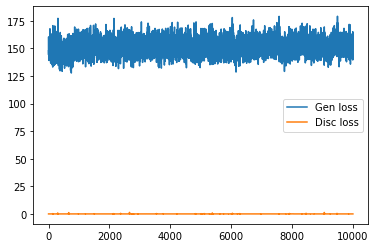

epoch: 96 	 step:0 	 loss: 155.5
epoch: 96 	 step:100 	 loss: 153.1
epoch: 96 	 step:200 	 loss: 138.3
epoch: 96 	 step:300 	 loss: 156.2
epoch: 96 	 step:400 	 loss: 163.2
epoch: 96 	 step:500 	 loss: 156.1
epoch: 96 	 step:600 	 loss: 134.4
epoch: 96 	 step:700 	 loss: 152.5
epoch: 96 	 step:800 	 loss: 151.1
epoch: 96 	 step:900 	 loss: 151.0
epoch: 96 	 step:1000 	 loss: 169.0
epoch: 96 	 step:1100 	 loss: 153.8
epoch: 96 	 step:1200 	 loss: 159.6
epoch: 96 	 step:1300 	 loss: 159.0
epoch: 96 	 step:1400 	 loss: 153.0
epoch: 96 	 step:1500 	 loss: 160.8
epoch: 96 	 step:1600 	 loss: 162.2
epoch: 96 	 step:1700 	 loss: 160.7
epoch: 96 	 step:1800 	 loss: 151.8


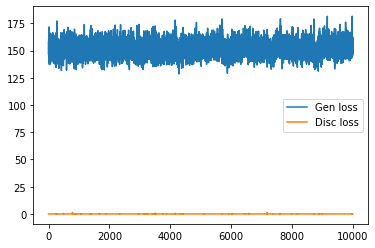

epoch: 97 	 step:0 	 loss: 153.2
epoch: 97 	 step:100 	 loss: 153.6
epoch: 97 	 step:200 	 loss: 152.4
epoch: 97 	 step:300 	 loss: 149.7
epoch: 97 	 step:400 	 loss: 166.6
epoch: 97 	 step:500 	 loss: 151.8
epoch: 97 	 step:600 	 loss: 158.1
epoch: 97 	 step:700 	 loss: 155.1
epoch: 97 	 step:800 	 loss: 140.6
epoch: 97 	 step:900 	 loss: 147.6
epoch: 97 	 step:1000 	 loss: 147.0
epoch: 97 	 step:1100 	 loss: 138.7
epoch: 97 	 step:1200 	 loss: 141.6
epoch: 97 	 step:1300 	 loss: 146.3
epoch: 97 	 step:1400 	 loss: 145.5
epoch: 97 	 step:1500 	 loss: 146.3
epoch: 97 	 step:1600 	 loss: 135.2
epoch: 97 	 step:1700 	 loss: 143.5
epoch: 97 	 step:1800 	 loss: 136.9


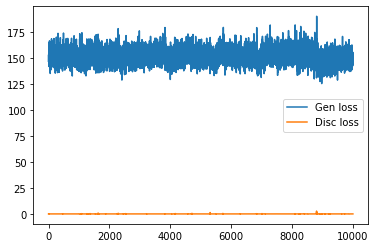

epoch: 98 	 step:0 	 loss: 147.7
epoch: 98 	 step:100 	 loss: 150.8
epoch: 98 	 step:200 	 loss: 153.3
epoch: 98 	 step:300 	 loss: 158.4
epoch: 98 	 step:400 	 loss: 149.0
epoch: 98 	 step:500 	 loss: 143.7
epoch: 98 	 step:600 	 loss: 157.0
epoch: 98 	 step:700 	 loss: 161.3
epoch: 98 	 step:800 	 loss: 155.2
epoch: 98 	 step:900 	 loss: 162.5
epoch: 98 	 step:1000 	 loss: 156.7
epoch: 98 	 step:1100 	 loss: 139.8
epoch: 98 	 step:1200 	 loss: 150.7
epoch: 98 	 step:1300 	 loss: 146.2
epoch: 98 	 step:1400 	 loss: 149.1
epoch: 98 	 step:1500 	 loss: 157.2
epoch: 98 	 step:1600 	 loss: 152.2
epoch: 98 	 step:1700 	 loss: 154.4
epoch: 98 	 step:1800 	 loss: 152.2


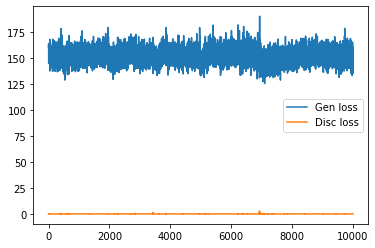

epoch: 99 	 step:0 	 loss: 158.4
epoch: 99 	 step:100 	 loss: 150.1
epoch: 99 	 step:200 	 loss: 159.7
epoch: 99 	 step:300 	 loss: 159.2
epoch: 99 	 step:400 	 loss: 147.1
epoch: 99 	 step:500 	 loss: 156.0
epoch: 99 	 step:600 	 loss: 161.1
epoch: 99 	 step:700 	 loss: 159.7
epoch: 99 	 step:800 	 loss: 146.6
epoch: 99 	 step:900 	 loss: 156.8
epoch: 99 	 step:1000 	 loss: 141.7
epoch: 99 	 step:1100 	 loss: 150.3
epoch: 99 	 step:1200 	 loss: 138.1
epoch: 99 	 step:1300 	 loss: 152.2
epoch: 99 	 step:1400 	 loss: 157.3
epoch: 99 	 step:1500 	 loss: 148.9
epoch: 99 	 step:1600 	 loss: 162.0
epoch: 99 	 step:1700 	 loss: 165.4
epoch: 99 	 step:1800 	 loss: 142.6


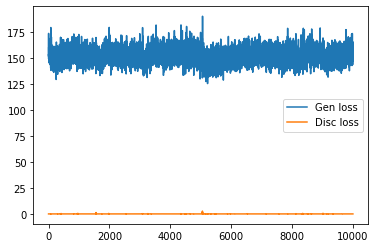

epoch: 100 	 step:0 	 loss: 161.5
epoch: 100 	 step:100 	 loss: 153.1
epoch: 100 	 step:200 	 loss: 150.4
epoch: 100 	 step:300 	 loss: 142.3
epoch: 100 	 step:400 	 loss: 150.2
epoch: 100 	 step:500 	 loss: 157.8
epoch: 100 	 step:600 	 loss: 152.1
epoch: 100 	 step:700 	 loss: 153.2
epoch: 100 	 step:800 	 loss: 152.9
epoch: 100 	 step:900 	 loss: 161.5
epoch: 100 	 step:1000 	 loss: 149.2
epoch: 100 	 step:1100 	 loss: 143.8
epoch: 100 	 step:1200 	 loss: 157.3
epoch: 100 	 step:1300 	 loss: 149.8
epoch: 100 	 step:1400 	 loss: 148.9
epoch: 100 	 step:1500 	 loss: 168.4
epoch: 100 	 step:1600 	 loss: 155.1
epoch: 100 	 step:1700 	 loss: 159.1
epoch: 100 	 step:1800 	 loss: 154.1


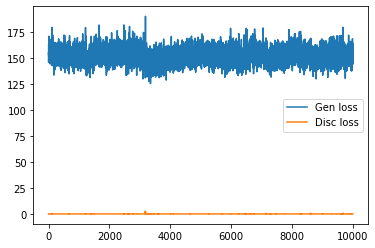

In [27]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/models/GAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name))
torch.save(disc_weights, "../cache/models/GAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name))

In [28]:
### LOAD MODEL ####

model_name = "gan784-lmd1e3"
z_size = 784

gen = models.FCNet(imsize=(1, 1, z_size), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/GAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/models/cGAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [29]:
def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        
        z = torch.randn(data.shape[0], 1, z_size).to(device)
        
        ouput = model(z)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [30]:
# Calculate test predictions #

test_predicted, test_original = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


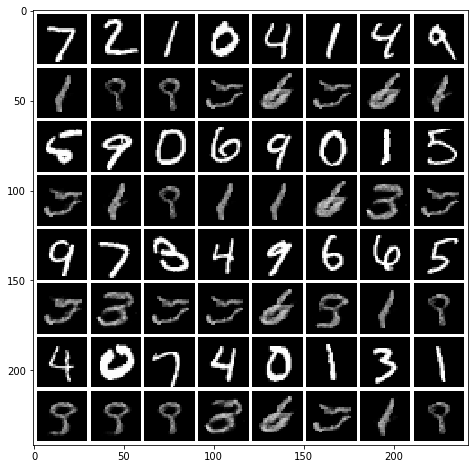

In [31]:
# Print test predictions 2 #
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/DPR/{}-raw.png".format(model_name))